In [1]:
import math 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os


import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from time import time

import warnings

import random

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action = 'ignore')

In [2]:
SEED = 123
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(SEED)

In [3]:
device = 'cuda'

In [4]:
def load_data_1m(path='./', delimiter='::', frac=0.1, seed=1234):

    tic = time()
    print('reading data...')
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    data = pd.read_csv('/Linux/Data/recommendation/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin1')
    data = np.array(data)
    print(data)
#     print(data[data[:,2] == 0])
    print('taken', time() - tic, 'seconds')

    n_u = np.unique(data[:,0]).size  # num of users
    n_m = np.unique(data[:,1]).size  # num of movies
    n_r = data.shape[0]  # num of ratings

    udict = {}
    for i, u in enumerate(np.unique(data[:,0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:,1]).tolist()):
        mdict[m] = i

    np.random.seed(seed)
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')
    train_user = []
    train_item = []
    train_rating = []
    test_user = []
    test_item = []
    test_rating = []
    
    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        if i < int(frac * n_r):
            test_r[mdict[m_id], udict[u_id]] = r
            test_user.append(udict[u_id])
            test_item.append(mdict[m_id])
            test_rating.append(r)
            
        else:
            train_r[mdict[m_id], udict[u_id]] = r
            train_user.append(udict[u_id])
            train_item.append(mdict[m_id])
            train_rating.append(r)

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')
    train_user = np.array(train_user).astype('float32') 
    train_item = np.array(train_item).astype('float32')
    train_rating = np.array(train_rating).astype('float32')
    test_user = np.array(test_user).astype('float32') 
    test_item = np.array(test_item).astype('float32') 
    test_rating = np.array(test_rating).astype('float32')
    
    
    
    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_r - int(frac * n_r)))
    print('num of test ratings: {}'.format(int(frac * n_r)))

    return n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating

In [5]:
path = '/Linux/Data/recommendation/ml-100k/'
n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)


reading data...
[[        1         1         5 874965758]
 [        1         2         3 876893171]
 [        1         3         4 878542960]
 ...
 [      943      1188         3 888640250]
 [      943      1228         3 888640275]
 [      943      1330         3 888692465]]
taken 0.15571975708007812 seconds
data matrix loaded
num of users: 943
num of movies: 1680
num of training ratings: 81513
num of test ratings: 9057


In [6]:
items = torch.LongTensor(train_item)
users = torch.LongTensor(train_user)
ratings = torch.FloatTensor(train_rating)
items_test = torch.LongTensor(test_item)
users_test = torch.LongTensor(test_user)
ratings_test = torch.FloatTensor(test_rating)

In [7]:
len(items), len(users), len(ratings)

(81513, 81513, 81513)

In [8]:
train_1 = pd.read_csv('../ml-100k/ua.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_1 = pd.read_csv('../ml-100k/ua.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
train_2 = pd.read_csv('../ml-100k/ub.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_2 = pd.read_csv('../ml-100k/ub.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])

In [9]:
# rank = 10

numItems = 1680
numUsers = 943

# P = torch.randn(numItems, rank, requires_grad=True)
# Q = torch.randn(numUsers, rank, requires_grad=True)

In [10]:
n_gaussians = 1
# n_hidden = 128
rank = 25
# reg_p = [1/n_gaussians] * n_gaussians
# reg_p = [0.8, 0.2]

In [11]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [12]:
def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * F.softmax(pi)
    result = torch.sum(result, dim=1)
    result = -torch.log(result+ 1e-6)
    return torch.mean(result)

In [13]:
# def regularization(p, k):
#     minus = torch.zeros(1,k)
#     result = []
#     for i in range(k):
#         minus[:,i] = 1
#         result.append(torch.mean(F.softmax(p), axis = 0) - minus)
#         minus = torch.zeros(1,k)
#     result = torch.sum(torch.square(torch.cat(result)))
#     return result

In [14]:
def regularization(p, k):
    result = torch.mean(F.softmax(p), axis = 0) - torch.Tensor(k).to(device)
    result = torch.sum(torch.square(result))
    return result

In [15]:
import torch
import torch.nn as nn

class PosLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(PosLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn((in_dim, out_dim)))
        self.bias = nn.Parameter(torch.zeros((out_dim,)))
        
    def forward(self, x):
        return torch.matmul(x, torch.abs(self.weight)) + torch.abs(self.bias)

In [16]:
layers_mean = PosLinear(rank, n_gaussians).to(device)
# layers_mean = nn.Sequential(
#             nn.Linear(rank, 128),
#             nn.Tanh(),
#             nn.Linear(128, n_gaussians)
# ).to(device)
# layers_mean = nn.Sequential(
#             PosLinear(rank, 128),
#             PosLinear(128, n_gaussians)
# ).to(device)
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)


In [17]:
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [18]:
bi = torch.nn.Parameter(torch.randn(numItems, requires_grad = True))
bu = torch.nn.Parameter(torch.randn(numUsers, requires_grad = True))

In [19]:
train_r1 = np.where(train_r == 0, 0, 1)
train_r2 = torch.from_numpy(train_r1)
mean = (ratings.sum()/len(ratings)).item()
y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2).to(device)
nu_y = torch.matmul(y_norm.unsqueeze(1).T, Y)
pnu = (P[items] + nu_y).sum(axis = 1)


In [20]:
pnu_test = (P[items_test] + nu_y).sum(axis = 1)

In [21]:
# test_r1 = np.where(test_r == 0, 0, 1)
# test_r2 = torch.from_numpy(test_r1)
# y_norm_test = torch.pow(torch.sum(test_r2, axis = 0) + 1, -1/2).to(device)
# nu_y_test = torch.matmul(y_norm_test.unsqueeze(1).T, Y)
# #pnu_test = (P[items_test] + nu_y_test).sum(axis = 1)

epoch: 0, train cost_P 4.443559, train cost: 2.107975, test cost: 2.126234, minimum test cost: 2.126234
means of test groups: tensor([[5.8554],
        [4.3073],
        [4.3622],
        [3.8955],
        [5.2378]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 4.])


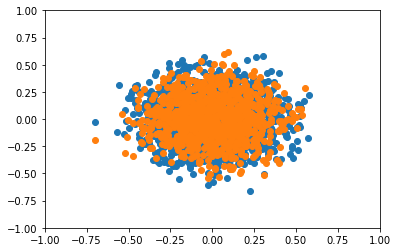

epoch: 100, train cost_P 1.532556, train cost: 1.237964, test cost: 1.265617, minimum test cost: 1.265617
means of test groups: tensor([[3.0696],
        [4.0528],
        [2.7355],
        [2.9454],
        [3.6476]], device='cuda:0')
ratings of test groups: tensor([2., 5., 4., 4., 2.])


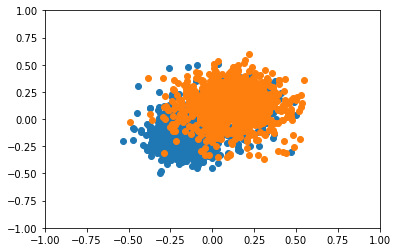

epoch: 200, train cost_P 1.381772, train cost: 1.175488, test cost: 1.204614, minimum test cost: 1.204614
means of test groups: tensor([[3.7147],
        [1.5579],
        [4.0161],
        [2.7136],
        [2.2886]], device='cuda:0')
ratings of test groups: tensor([4., 2., 4., 5., 1.])


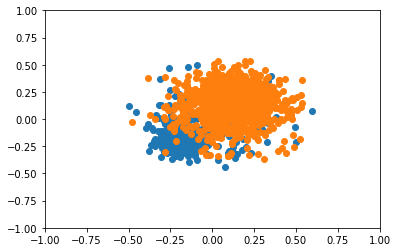

epoch: 300, train cost_P 1.331255, train cost: 1.153800, test cost: 1.183453, minimum test cost: 1.183453
means of test groups: tensor([[4.3462],
        [3.0765],
        [3.2287],
        [2.9339],
        [3.3825]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 4., 4.])


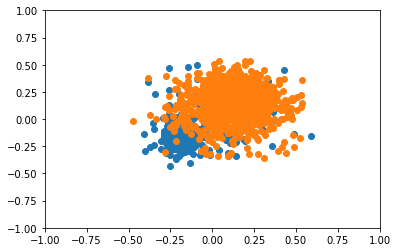

epoch: 400, train cost_P 1.287309, train cost: 1.134596, test cost: 1.164872, minimum test cost: 1.164872
means of test groups: tensor([[4.5064],
        [3.5232],
        [3.1564],
        [3.4675],
        [4.1773]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 4.])


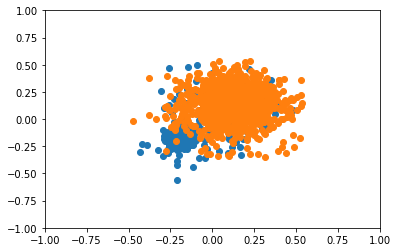

epoch: 500, train cost_P 1.246850, train cost: 1.116625, test cost: 1.147588, minimum test cost: 1.147588
means of test groups: tensor([[2.4610],
        [4.1922],
        [3.9948],
        [3.4624],
        [3.8452]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 3., 4.])


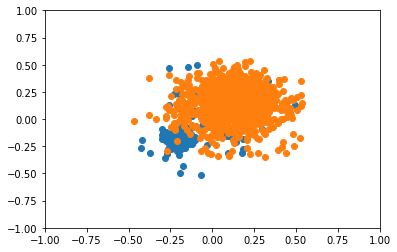

epoch: 600, train cost_P 1.209603, train cost: 1.099820, test cost: 1.131491, minimum test cost: 1.131491
means of test groups: tensor([[5.5739],
        [2.7819],
        [3.0851],
        [2.7512],
        [3.7374]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 1., 4.])


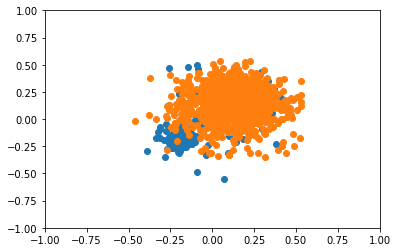

epoch: 700, train cost_P 1.175408, train cost: 1.084162, test cost: 1.116517, minimum test cost: 1.116517
means of test groups: tensor([[4.5531],
        [2.8135],
        [3.3444],
        [3.6655],
        [2.9467]], device='cuda:0')
ratings of test groups: tensor([5., 4., 4., 3., 4.])


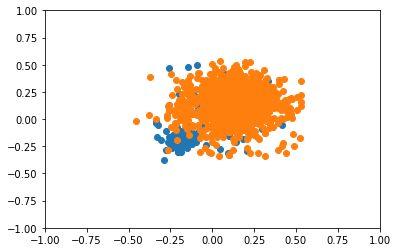

epoch: 800, train cost_P 1.144064, train cost: 1.069609, test cost: 1.102663, minimum test cost: 1.102663
means of test groups: tensor([[3.9894],
        [3.3780],
        [4.2735],
        [2.8293],
        [2.7851]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 1., 2.])


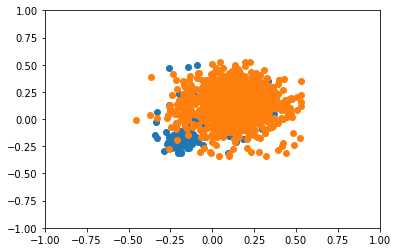

epoch: 900, train cost_P 1.115393, train cost: 1.056122, test cost: 1.089897, minimum test cost: 1.089897
means of test groups: tensor([[4.0211],
        [4.2795],
        [3.4401],
        [3.0850],
        [3.1969]], device='cuda:0')
ratings of test groups: tensor([4., 4., 2., 3., 2.])


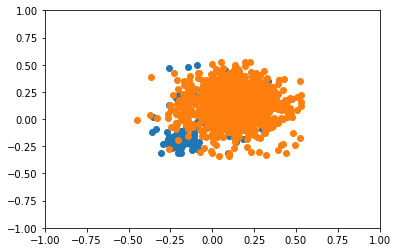

epoch: 1000, train cost_P 1.089211, train cost: 1.043653, test cost: 1.078140, minimum test cost: 1.078140
means of test groups: tensor([[3.1362],
        [3.8562],
        [3.3427],
        [3.2884],
        [4.1148]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 5., 5.])


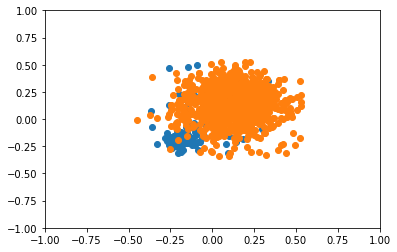

epoch: 1100, train cost_P 1.065325, train cost: 1.032146, test cost: 1.067324, minimum test cost: 1.067324
means of test groups: tensor([[3.3906],
        [3.4463],
        [3.0874],
        [3.2742],
        [4.8891]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 5., 4.])


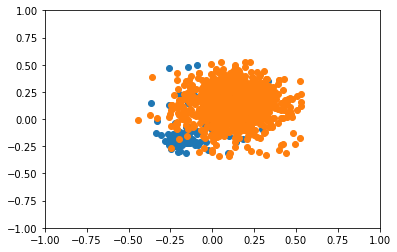

epoch: 1200, train cost_P 1.043537, train cost: 1.021537, test cost: 1.057350, minimum test cost: 1.057350
means of test groups: tensor([[3.3601],
        [3.9171],
        [2.9941],
        [5.0310],
        [2.4606]], device='cuda:0')
ratings of test groups: tensor([3., 5., 5., 5., 3.])


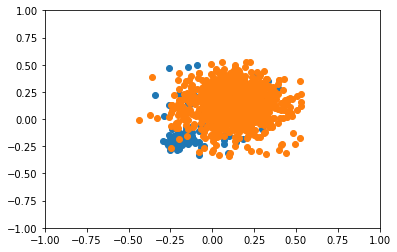

epoch: 1300, train cost_P 1.023692, train cost: 1.011777, test cost: 1.048206, minimum test cost: 1.048206
means of test groups: tensor([[2.9975],
        [3.8890],
        [3.0857],
        [3.1032],
        [3.7805]], device='cuda:0')
ratings of test groups: tensor([2., 5., 3., 3., 5.])


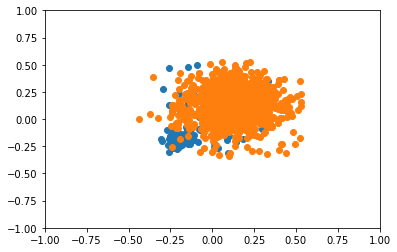

epoch: 1400, train cost_P 1.005598, train cost: 1.002795, test cost: 1.039839, minimum test cost: 1.039839
means of test groups: tensor([[3.9340],
        [3.0069],
        [3.2568],
        [3.0754],
        [4.0118]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 3., 5.])


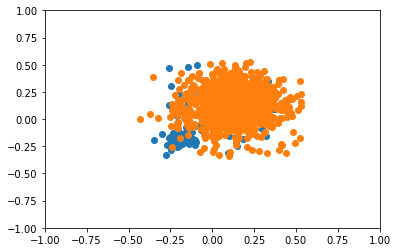

epoch: 1500, train cost_P 0.989108, train cost: 0.994539, test cost: 1.032177, minimum test cost: 1.032177
means of test groups: tensor([[2.5865],
        [2.5439],
        [3.9325],
        [2.1076],
        [3.9317]], device='cuda:0')
ratings of test groups: tensor([3., 2., 5., 1., 4.])


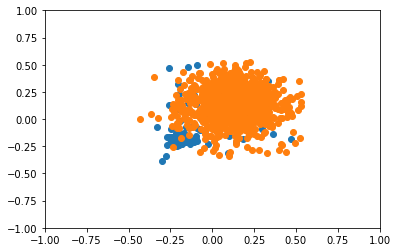

epoch: 1600, train cost_P 0.974087, train cost: 0.986958, test cost: 1.025196, minimum test cost: 1.025196
means of test groups: tensor([[3.0532],
        [3.2249],
        [4.4685],
        [3.1688],
        [4.5745]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 3., 5.])


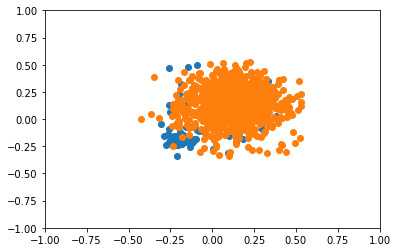

epoch: 1700, train cost_P 0.960392, train cost: 0.979996, test cost: 1.018816, minimum test cost: 1.018816
means of test groups: tensor([[4.7279],
        [3.6531],
        [3.5906],
        [3.1741],
        [3.2034]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 3., 3.])


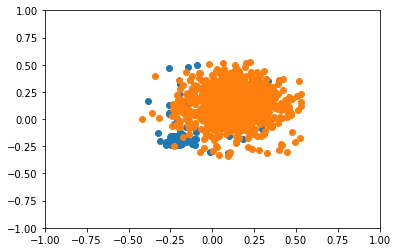

epoch: 1800, train cost_P 0.947903, train cost: 0.973603, test cost: 1.012971, minimum test cost: 1.012971
means of test groups: tensor([[3.3654],
        [4.4102],
        [4.5484],
        [3.5786],
        [4.1379]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 4., 5.])


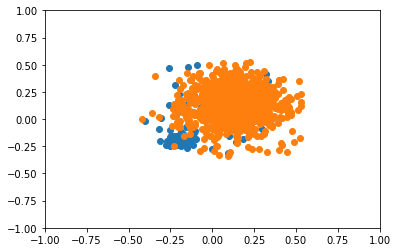

epoch: 1900, train cost_P 0.936515, train cost: 0.967737, test cost: 1.007633, minimum test cost: 1.007633
means of test groups: tensor([[4.0348],
        [2.8735],
        [1.4149],
        [3.5163],
        [3.5010]], device='cuda:0')
ratings of test groups: tensor([4., 3., 1., 4., 4.])


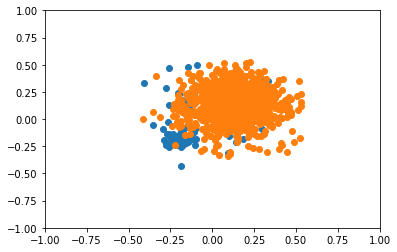

epoch: 2000, train cost_P 0.926138, train cost: 0.962361, test cost: 1.002787, minimum test cost: 1.002787
means of test groups: tensor([[3.5253],
        [4.3772],
        [4.1258],
        [2.7838],
        [2.7331]], device='cuda:0')
ratings of test groups: tensor([3., 2., 5., 4., 1.])


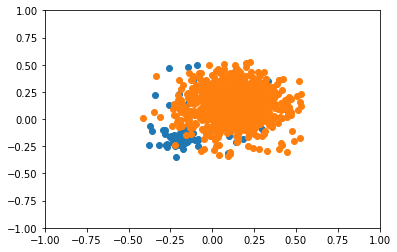

epoch: 2100, train cost_P 0.916682, train cost: 0.957435, test cost: 0.998371, minimum test cost: 0.998371
means of test groups: tensor([[3.5786],
        [3.5378],
        [4.0512],
        [4.3844],
        [4.1067]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 2., 4.])


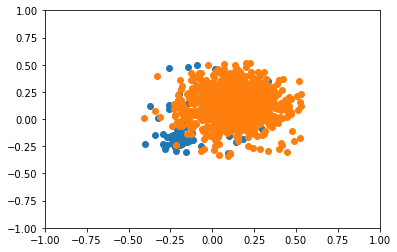

epoch: 2200, train cost_P 0.908071, train cost: 0.952927, test cost: 0.994415, minimum test cost: 0.994415
means of test groups: tensor([[4.0079],
        [4.4299],
        [4.5392],
        [4.4663],
        [3.6490]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 4., 3.])


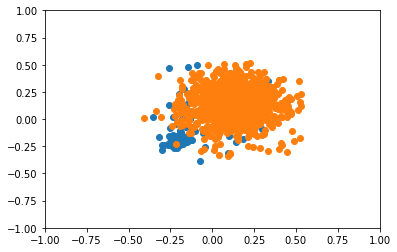

epoch: 2300, train cost_P 0.900229, train cost: 0.948804, test cost: 0.990764, minimum test cost: 0.990764
means of test groups: tensor([[4.2502],
        [4.2853],
        [2.8429],
        [2.9789],
        [3.2716]], device='cuda:0')
ratings of test groups: tensor([5., 5., 4., 3., 3.])


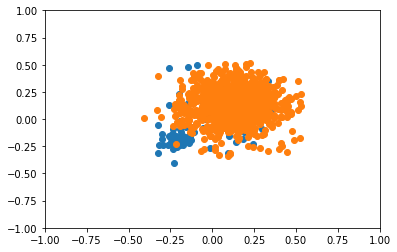

epoch: 2400, train cost_P 0.893090, train cost: 0.945034, test cost: 0.987463, minimum test cost: 0.987463
means of test groups: tensor([[3.0380],
        [2.8959],
        [3.6433],
        [3.8710],
        [3.4325]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 4., 3.])


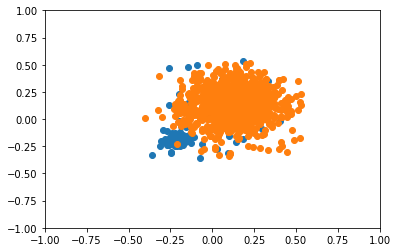

epoch: 2500, train cost_P 0.886594, train cost: 0.941591, test cost: 0.984457, minimum test cost: 0.984457
means of test groups: tensor([[3.3229],
        [3.5115],
        [3.3762],
        [2.1733],
        [4.0100]], device='cuda:0')
ratings of test groups: tensor([4., 2., 3., 2., 5.])


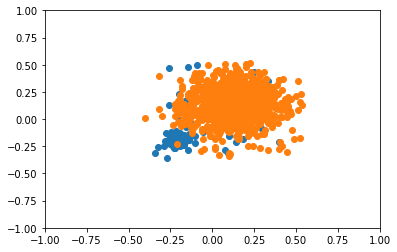

epoch: 2600, train cost_P 0.880686, train cost: 0.938449, test cost: 0.981755, minimum test cost: 0.981755
means of test groups: tensor([[3.3154],
        [4.4206],
        [4.0960],
        [3.2686],
        [4.0034]], device='cuda:0')
ratings of test groups: tensor([1., 3., 5., 4., 5.])


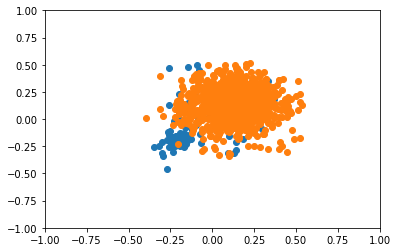

epoch: 2700, train cost_P 0.875314, train cost: 0.935582, test cost: 0.979240, minimum test cost: 0.979240
means of test groups: tensor([[4.1463],
        [2.8234],
        [3.0450],
        [3.6224],
        [3.8302]], device='cuda:0')
ratings of test groups: tensor([4., 3., 1., 3., 4.])


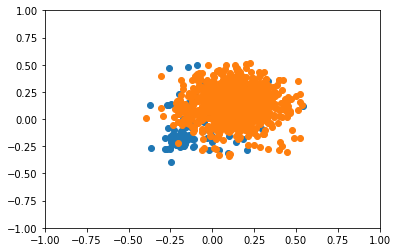

epoch: 2800, train cost_P 0.870430, train cost: 0.932968, test cost: 0.976970, minimum test cost: 0.976970
means of test groups: tensor([[4.0223],
        [3.9581],
        [3.4463],
        [4.6882],
        [2.0264]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 5., 3.])


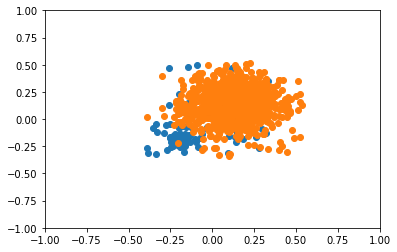

epoch: 2900, train cost_P 0.866006, train cost: 0.930594, test cost: 0.974938, minimum test cost: 0.974938
means of test groups: tensor([[3.9719],
        [3.4010],
        [3.4195],
        [3.3348],
        [3.6178]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 1., 4.])


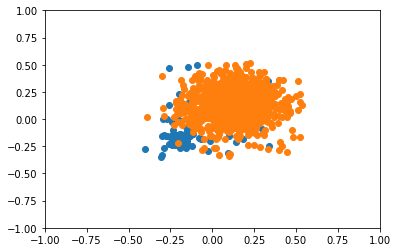

epoch: 3000, train cost_P 0.861998, train cost: 0.928439, test cost: 0.973106, minimum test cost: 0.973103
means of test groups: tensor([[4.0618],
        [2.8972],
        [3.2902],
        [4.1175],
        [3.6080]], device='cuda:0')
ratings of test groups: tensor([4., 1., 3., 4., 3.])


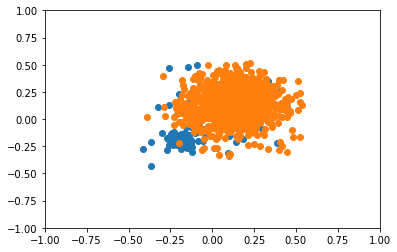

epoch: 3100, train cost_P 0.858348, train cost: 0.926471, test cost: 0.971452, minimum test cost: 0.971364
means of test groups: tensor([[3.4646],
        [3.6534],
        [3.8696],
        [2.8976],
        [4.3588]], device='cuda:0')
ratings of test groups: tensor([2., 4., 3., 3., 5.])


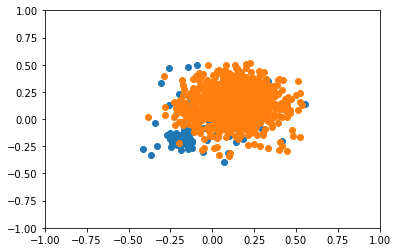

epoch: 3200, train cost_P 0.855029, train cost: 0.924678, test cost: 0.969917, minimum test cost: 0.969853
means of test groups: tensor([[4.0452],
        [3.7296],
        [3.8760],
        [3.6343],
        [4.5837]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 4.])


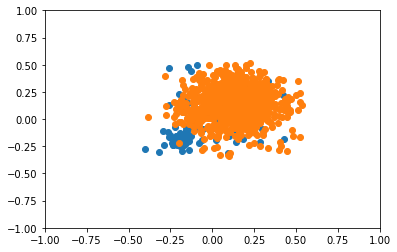

epoch: 3300, train cost_P 0.852010, train cost: 0.923044, test cost: 0.968484, minimum test cost: 0.968455
means of test groups: tensor([[4.2336],
        [3.8604],
        [3.1883],
        [4.1997],
        [3.2161]], device='cuda:0')
ratings of test groups: tensor([3., 4., 1., 4., 3.])


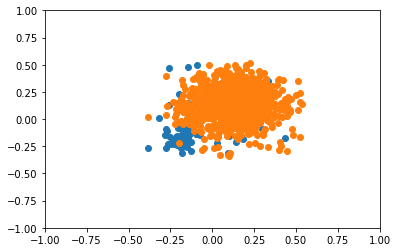

epoch: 3400, train cost_P 0.849265, train cost: 0.921556, test cost: 0.967206, minimum test cost: 0.967180
means of test groups: tensor([[2.8317],
        [3.4476],
        [4.3716],
        [2.8030],
        [3.7751]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 1., 4.])


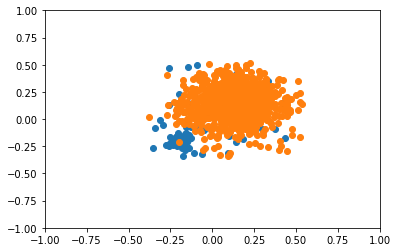

epoch: 3500, train cost_P 0.846774, train cost: 0.920203, test cost: 0.966120, minimum test cost: 0.966025
means of test groups: tensor([[3.7546],
        [3.0530],
        [3.4097],
        [3.9956],
        [3.4575]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 3., 3.])


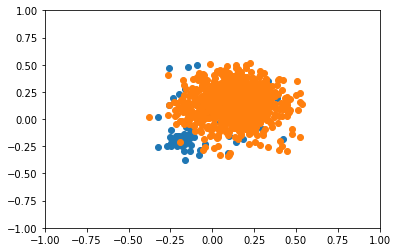

epoch: 3600, train cost_P 0.844511, train cost: 0.918973, test cost: 0.965073, minimum test cost: 0.964981
means of test groups: tensor([[2.4772],
        [2.9078],
        [3.5451],
        [3.4899],
        [2.9693]], device='cuda:0')
ratings of test groups: tensor([3., 2., 5., 3., 3.])


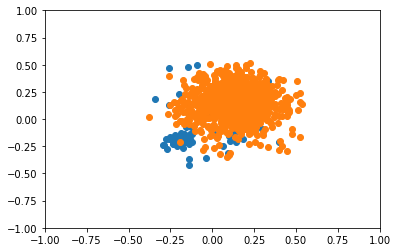

epoch: 3700, train cost_P 0.842445, train cost: 0.917848, test cost: 0.964093, minimum test cost: 0.964058
means of test groups: tensor([[2.1597],
        [3.3792],
        [3.1137],
        [3.7390],
        [2.9911]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 3., 4.])


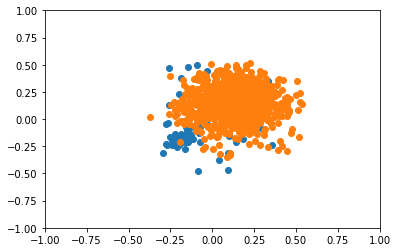

epoch: 3800, train cost_P 0.840559, train cost: 0.916820, test cost: 0.963200, minimum test cost: 0.963179
means of test groups: tensor([[3.5561],
        [2.9349],
        [3.1176],
        [4.2453],
        [4.0720]], device='cuda:0')
ratings of test groups: tensor([4., 4., 2., 5., 5.])


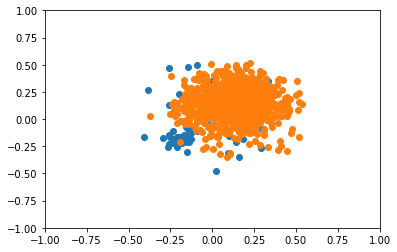

epoch: 3900, train cost_P 0.838826, train cost: 0.915874, test cost: 0.962501, minimum test cost: 0.962423
means of test groups: tensor([[2.9940],
        [3.2255],
        [3.1807],
        [4.4838],
        [3.2982]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 5., 4.])


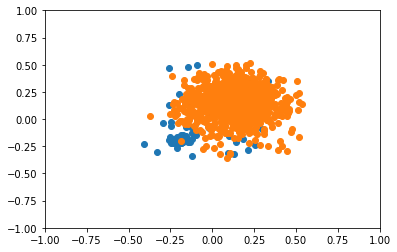

epoch: 4000, train cost_P 0.837264, train cost: 0.915021, test cost: 0.961853, minimum test cost: 0.961678
means of test groups: tensor([[4.6590],
        [1.9535],
        [4.3466],
        [3.8868],
        [3.2905]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 5., 3.])


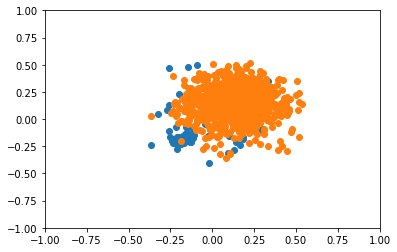

epoch: 4100, train cost_P 0.835836, train cost: 0.914241, test cost: 0.961241, minimum test cost: 0.961033
means of test groups: tensor([[3.8937],
        [3.6147],
        [3.5488],
        [3.3941],
        [2.7495]], device='cuda:0')
ratings of test groups: tensor([4., 2., 4., 3., 1.])


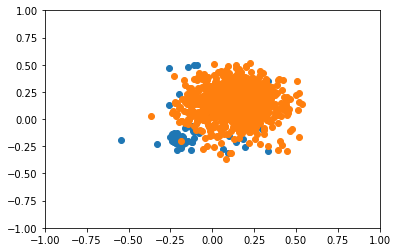

epoch: 4200, train cost_P 0.834531, train cost: 0.913527, test cost: 0.960680, minimum test cost: 0.960459
means of test groups: tensor([[3.8860],
        [2.8172],
        [3.5633],
        [2.8117],
        [3.7923]], device='cuda:0')
ratings of test groups: tensor([2., 1., 3., 1., 3.])


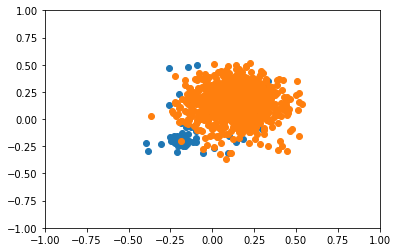

epoch: 4300, train cost_P 0.833348, train cost: 0.912879, test cost: 0.960166, minimum test cost: 0.960014
means of test groups: tensor([[4.4601],
        [3.4377],
        [2.6807],
        [4.0177],
        [2.9967]], device='cuda:0')
ratings of test groups: tensor([4., 1., 1., 5., 3.])


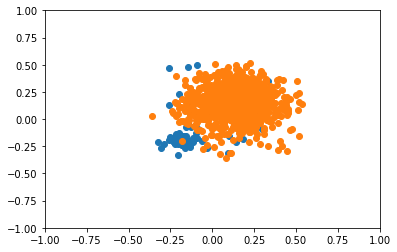

epoch: 4400, train cost_P 0.832278, train cost: 0.912292, test cost: 0.959692, minimum test cost: 0.959593
means of test groups: tensor([[2.3448],
        [3.6991],
        [4.1319],
        [3.0959],
        [3.2046]], device='cuda:0')
ratings of test groups: tensor([1., 2., 5., 2., 3.])


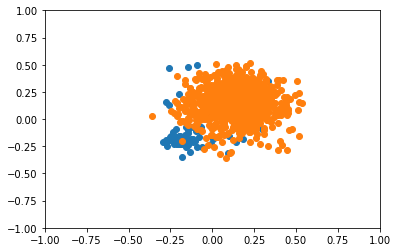

epoch: 4500, train cost_P 0.831304, train cost: 0.911759, test cost: 0.959274, minimum test cost: 0.959203
means of test groups: tensor([[2.8591],
        [3.3859],
        [2.6803],
        [5.1464],
        [3.3910]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 5., 4.])


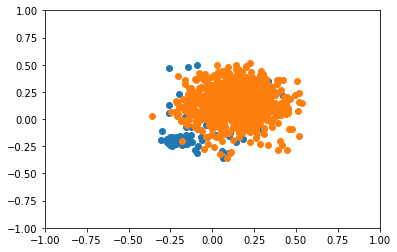

epoch: 4600, train cost_P 0.830398, train cost: 0.911262, test cost: 0.958932, minimum test cost: 0.958816
means of test groups: tensor([[4.6719],
        [3.8307],
        [2.2069],
        [4.2330],
        [4.1319]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 4., 5.])


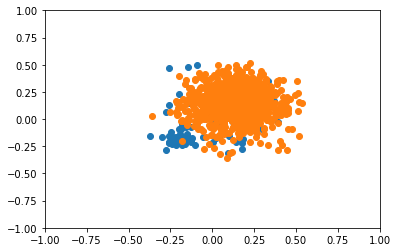

epoch: 4700, train cost_P 0.829564, train cost: 0.910804, test cost: 0.958590, minimum test cost: 0.958507
means of test groups: tensor([[3.9998],
        [2.9483],
        [3.6092],
        [2.2179],
        [3.5213]], device='cuda:0')
ratings of test groups: tensor([4., 1., 4., 3., 4.])


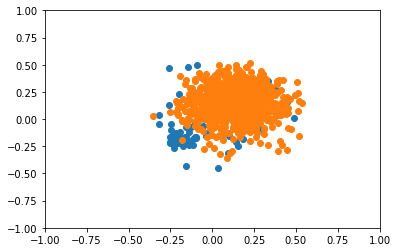

epoch: 4800, train cost_P 0.828808, train cost: 0.910389, test cost: 0.958390, minimum test cost: 0.958194
means of test groups: tensor([[3.4040],
        [3.0003],
        [3.6273],
        [3.8210],
        [2.9473]], device='cuda:0')
ratings of test groups: tensor([4., 1., 3., 5., 1.])


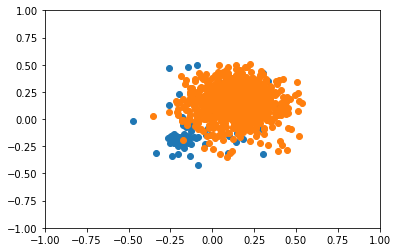

epoch: 4900, train cost_P 0.828114, train cost: 0.910008, test cost: 0.958056, minimum test cost: 0.957965
means of test groups: tensor([[3.9285],
        [2.3493],
        [3.3540],
        [4.3309],
        [2.4058]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 5., 3.])


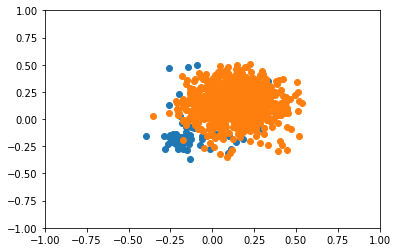

epoch: 5000, train cost_P 0.827468, train cost: 0.909653, test cost: 0.957845, minimum test cost: 0.957726
means of test groups: tensor([[3.9565],
        [4.0720],
        [3.2247],
        [3.9915],
        [3.8072]], device='cuda:0')
ratings of test groups: tensor([5., 4., 5., 5., 4.])


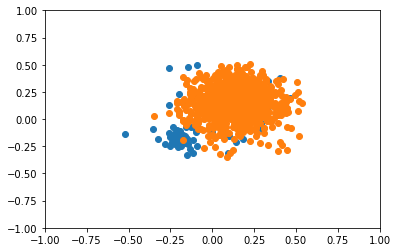

epoch: 5100, train cost_P 0.826876, train cost: 0.909327, test cost: 0.957651, minimum test cost: 0.957532
means of test groups: tensor([[3.2380],
        [3.4557],
        [2.3991],
        [3.2366],
        [3.7154]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 2., 3.])


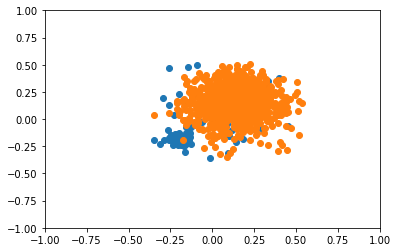

epoch: 5200, train cost_P 0.826329, train cost: 0.909026, test cost: 0.957541, minimum test cost: 0.957291
means of test groups: tensor([[2.8176],
        [3.4412],
        [4.5333],
        [3.2760],
        [3.1779]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 4., 4.])


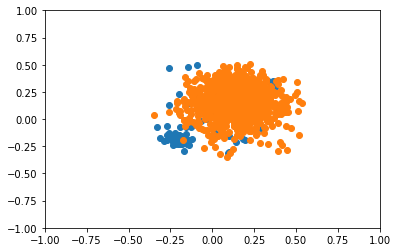

epoch: 5300, train cost_P 0.825817, train cost: 0.908745, test cost: 0.957428, minimum test cost: 0.957150
means of test groups: tensor([[2.7240],
        [3.4889],
        [4.1111],
        [3.5153],
        [2.9210]], device='cuda:0')
ratings of test groups: tensor([3., 2., 3., 5., 2.])


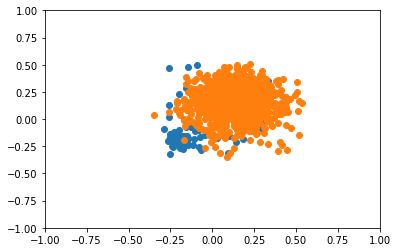

epoch: 5400, train cost_P 0.825340, train cost: 0.908482, test cost: 0.957200, minimum test cost: 0.956986
means of test groups: tensor([[2.3007],
        [3.8040],
        [2.9715],
        [3.9490],
        [4.7245]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 4., 5.])


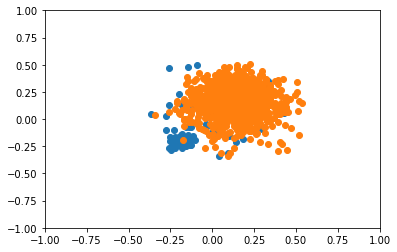

epoch: 5500, train cost_P 0.824917, train cost: 0.908249, test cost: 0.957125, minimum test cost: 0.956890
means of test groups: tensor([[3.1275],
        [3.6144],
        [4.2146],
        [3.5203],
        [4.1339]], device='cuda:0')
ratings of test groups: tensor([3., 1., 5., 5., 5.])


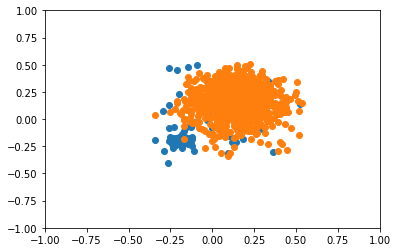

epoch: 5600, train cost_P 0.824517, train cost: 0.908029, test cost: 0.956930, minimum test cost: 0.956840
means of test groups: tensor([[4.1522],
        [2.9470],
        [2.9290],
        [3.6862],
        [3.7262]], device='cuda:0')
ratings of test groups: tensor([2., 3., 3., 4., 4.])


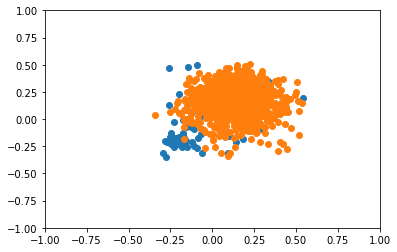

epoch: 5700, train cost_P 0.824140, train cost: 0.907822, test cost: 0.956835, minimum test cost: 0.956764
means of test groups: tensor([[2.4262],
        [4.6235],
        [3.4327],
        [1.4630],
        [3.0221]], device='cuda:0')
ratings of test groups: tensor([3., 3., 2., 1., 2.])


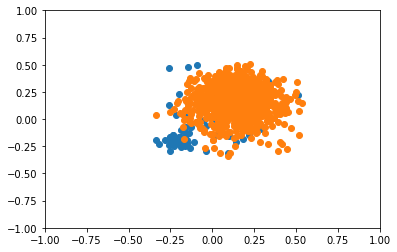

epoch: 5800, train cost_P 0.823799, train cost: 0.907634, test cost: 0.956801, minimum test cost: 0.956653
means of test groups: tensor([[3.3358],
        [3.3092],
        [3.0253],
        [3.8903],
        [3.5381]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 3.])


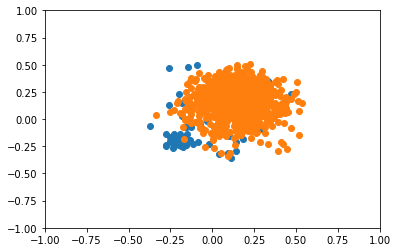

epoch: 5900, train cost_P 0.823468, train cost: 0.907451, test cost: 0.956782, minimum test cost: 0.956510
means of test groups: tensor([[3.8379],
        [3.3641],
        [4.1763],
        [3.8770],
        [3.9169]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 5., 3.])


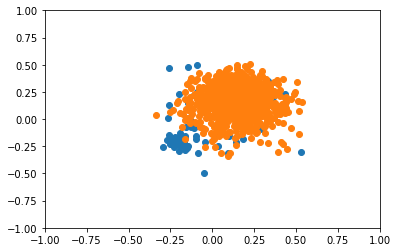

epoch: 6000, train cost_P 0.823162, train cost: 0.907283, test cost: 0.956656, minimum test cost: 0.956476
means of test groups: tensor([[3.2683],
        [3.6576],
        [2.7091],
        [4.1456],
        [3.6849]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 5., 4.])


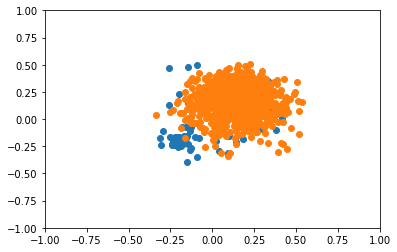

epoch: 6100, train cost_P 0.822877, train cost: 0.907126, test cost: 0.956724, minimum test cost: 0.956476
means of test groups: tensor([[3.1991],
        [3.9188],
        [4.0514],
        [3.3955],
        [3.3195]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 4., 2.])


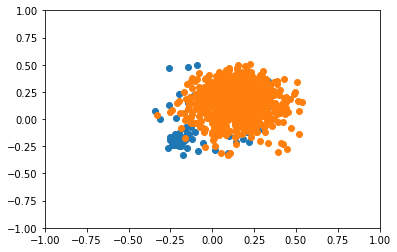

epoch: 6200, train cost_P 0.822596, train cost: 0.906971, test cost: 0.956673, minimum test cost: 0.956390
means of test groups: tensor([[3.8455],
        [3.9103],
        [3.8423],
        [3.5682],
        [4.2571]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 5., 3.])


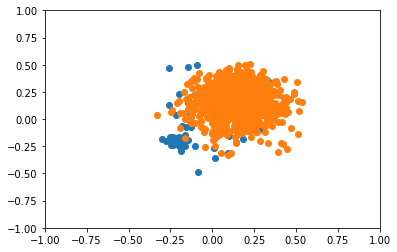

epoch: 6300, train cost_P 0.822342, train cost: 0.906831, test cost: 0.956627, minimum test cost: 0.956390
means of test groups: tensor([[3.2547],
        [2.2365],
        [3.2964],
        [3.5154],
        [3.5715]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 3., 3.])


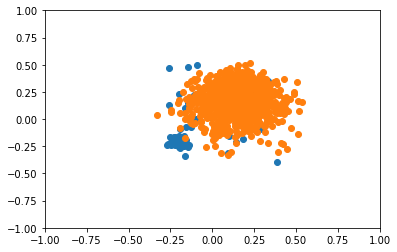

epoch: 6400, train cost_P 0.822096, train cost: 0.906695, test cost: 0.956616, minimum test cost: 0.956361
means of test groups: tensor([[3.7006],
        [3.9263],
        [4.0275],
        [3.7637],
        [3.5498]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 3., 3.])


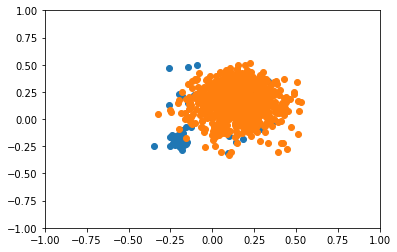

epoch: 6500, train cost_P 0.821889, train cost: 0.906581, test cost: 0.956701, minimum test cost: 0.956317
means of test groups: tensor([[3.0935],
        [4.1012],
        [3.1256],
        [3.5848],
        [3.4655]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 3., 4.])


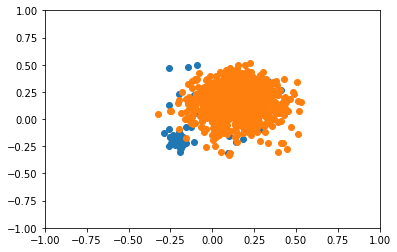

epoch: 6600, train cost_P 0.821694, train cost: 0.906473, test cost: 0.956489, minimum test cost: 0.956316
means of test groups: tensor([[3.1848],
        [1.8007],
        [3.3387],
        [3.8919],
        [2.5889]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 4., 4.])


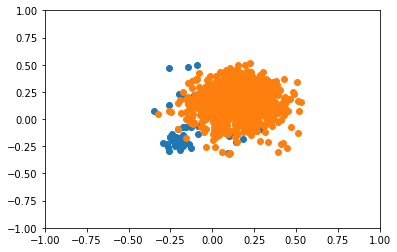

epoch: 6700, train cost_P 0.821546, train cost: 0.906392, test cost: 0.956561, minimum test cost: 0.956316
means of test groups: tensor([[3.9975],
        [3.4996],
        [4.4547],
        [3.7003],
        [2.3638]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 3.])


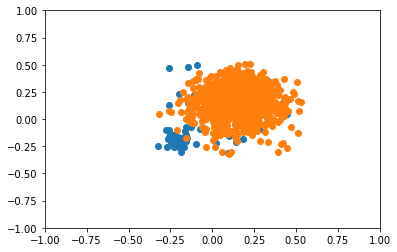

epoch: 6800, train cost_P 0.821405, train cost: 0.906314, test cost: 0.956696, minimum test cost: 0.956316
means of test groups: tensor([[2.2465],
        [2.7038],
        [3.8544],
        [2.8028],
        [3.0372]], device='cuda:0')
ratings of test groups: tensor([3., 2., 5., 3., 5.])


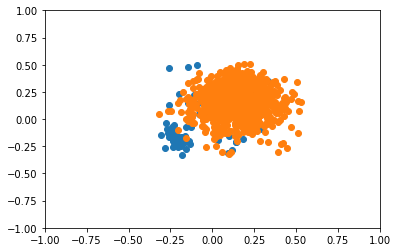

epoch: 6900, train cost_P 0.821329, train cost: 0.906272, test cost: 0.956764, minimum test cost: 0.956264
means of test groups: tensor([[1.6125],
        [2.8931],
        [2.4929],
        [2.7944],
        [2.3380]], device='cuda:0')
ratings of test groups: tensor([1., 4., 1., 4., 2.])


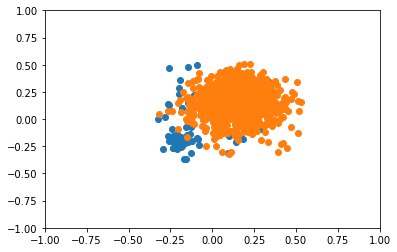

epoch: 7000, train cost_P 0.820998, train cost: 0.906089, test cost: 0.956808, minimum test cost: 0.956264
means of test groups: tensor([[2.9347],
        [4.7332],
        [3.9830],
        [2.3224],
        [4.0732]], device='cuda:0')
ratings of test groups: tensor([2., 5., 4., 2., 3.])


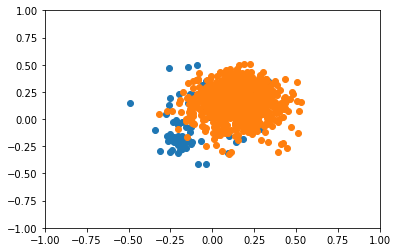

epoch: 7100, train cost_P 0.820800, train cost: 0.905980, test cost: 0.956714, minimum test cost: 0.956202
means of test groups: tensor([[2.6059],
        [4.1965],
        [3.3346],
        [2.2595],
        [3.5216]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 3., 4.])


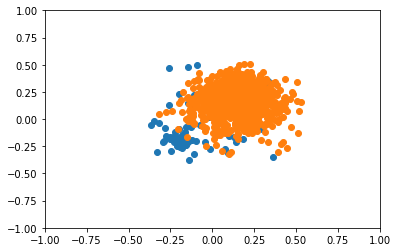

epoch: 7200, train cost_P 0.820672, train cost: 0.905910, test cost: 0.956819, minimum test cost: 0.956202
means of test groups: tensor([[4.0330],
        [2.6461],
        [2.4837],
        [3.5542],
        [4.4490]], device='cuda:0')
ratings of test groups: tensor([4., 3., 1., 4., 5.])


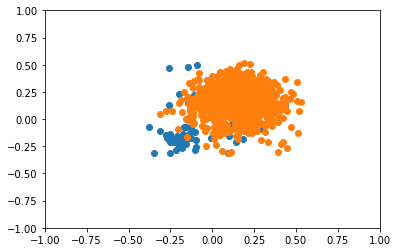

epoch: 7300, train cost_P 0.820467, train cost: 0.905796, test cost: 0.956817, minimum test cost: 0.956202
means of test groups: tensor([[3.2854],
        [2.3210],
        [3.5212],
        [2.5410],
        [3.4573]], device='cuda:0')
ratings of test groups: tensor([3., 1., 5., 3., 2.])


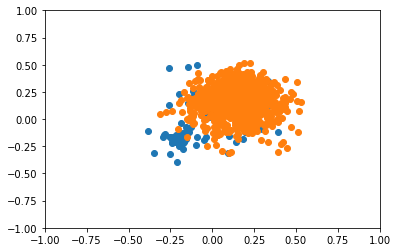

epoch: 7400, train cost_P 0.820234, train cost: 0.905668, test cost: 0.956589, minimum test cost: 0.956202
means of test groups: tensor([[1.7579],
        [3.7114],
        [3.4017],
        [3.0517],
        [3.6961]], device='cuda:0')
ratings of test groups: tensor([1., 4., 5., 3., 3.])


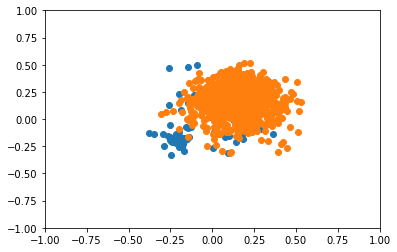

epoch: 7500, train cost_P 0.820110, train cost: 0.905599, test cost: 0.956780, minimum test cost: 0.956202
means of test groups: tensor([[3.5054],
        [3.9415],
        [4.7945],
        [2.5167],
        [4.3682]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 2., 4.])


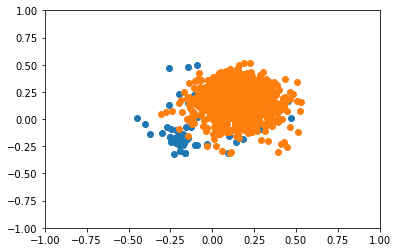

epoch: 7600, train cost_P 0.819941, train cost: 0.905506, test cost: 0.956601, minimum test cost: 0.956202
means of test groups: tensor([[3.0180],
        [3.5718],
        [3.1079],
        [4.2248],
        [2.4829]], device='cuda:0')
ratings of test groups: tensor([4., 3., 2., 4., 3.])


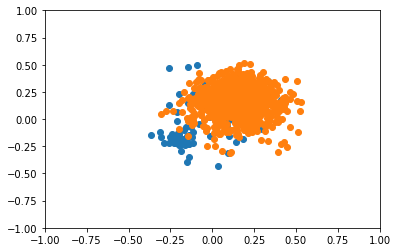

epoch: 7700, train cost_P 0.819826, train cost: 0.905442, test cost: 0.956649, minimum test cost: 0.956202
means of test groups: tensor([[4.1931],
        [2.9729],
        [3.2081],
        [3.7632],
        [2.7089]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 4., 2.])


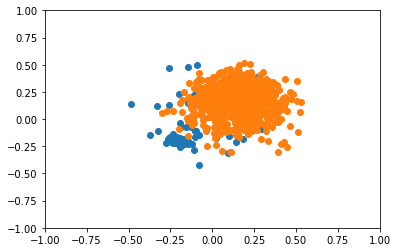

epoch: 7800, train cost_P 0.819730, train cost: 0.905390, test cost: 0.956647, minimum test cost: 0.956202
means of test groups: tensor([[4.0054],
        [3.5369],
        [3.9294],
        [3.6933],
        [3.6311]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 4., 3.])


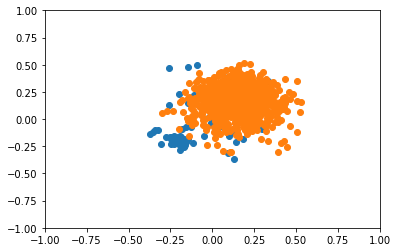

epoch: 7900, train cost_P 0.819646, train cost: 0.905343, test cost: 0.956861, minimum test cost: 0.956202
means of test groups: tensor([[3.4791],
        [3.5407],
        [2.8630],
        [3.6650],
        [2.7014]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 4., 5.])


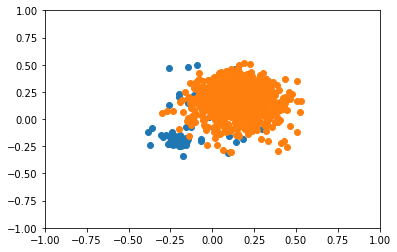

epoch: 8000, train cost_P 0.819430, train cost: 0.905224, test cost: 0.956726, minimum test cost: 0.956202
means of test groups: tensor([[4.4694],
        [2.9259],
        [3.4897],
        [3.9143],
        [3.0461]], device='cuda:0')
ratings of test groups: tensor([4., 2., 3., 3., 4.])


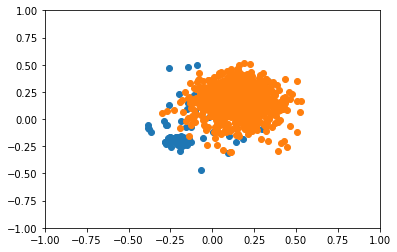

epoch: 8100, train cost_P 0.819304, train cost: 0.905154, test cost: 0.956789, minimum test cost: 0.956202
means of test groups: tensor([[2.5510],
        [2.1846],
        [3.2492],
        [4.2758],
        [3.4462]], device='cuda:0')
ratings of test groups: tensor([2., 2., 4., 4., 3.])


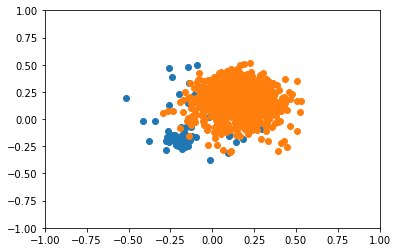

epoch: 8200, train cost_P 0.819190, train cost: 0.905091, test cost: 0.956867, minimum test cost: 0.956202
means of test groups: tensor([[2.7115],
        [3.6747],
        [3.2519],
        [3.3605],
        [4.8017]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 5., 5.])


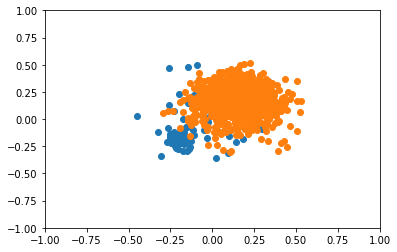

epoch: 8300, train cost_P 0.819031, train cost: 0.905003, test cost: 0.956933, minimum test cost: 0.956202
means of test groups: tensor([[2.9307],
        [3.0599],
        [4.6757],
        [3.9184],
        [4.2701]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 5., 4.])


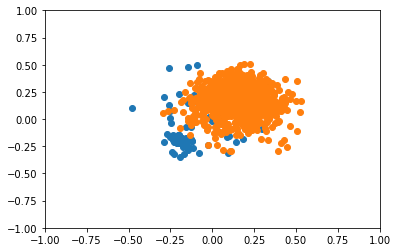

epoch: 8400, train cost_P 0.818924, train cost: 0.904944, test cost: 0.956815, minimum test cost: 0.956202
means of test groups: tensor([[3.3945],
        [3.2828],
        [2.7939],
        [3.3945],
        [4.2527]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 5., 4.])


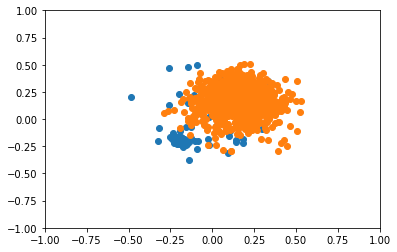

epoch: 8500, train cost_P 0.818803, train cost: 0.904877, test cost: 0.956828, minimum test cost: 0.956202
means of test groups: tensor([[4.1980],
        [3.4604],
        [2.6370],
        [4.0069],
        [3.9466]], device='cuda:0')
ratings of test groups: tensor([5., 5., 2., 3., 3.])


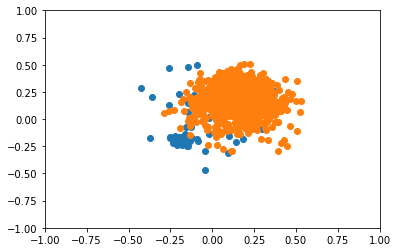

epoch: 8600, train cost_P 0.818693, train cost: 0.904817, test cost: 0.956887, minimum test cost: 0.956202
means of test groups: tensor([[3.2166],
        [4.5866],
        [3.6020],
        [3.5521],
        [4.9178]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 3., 5.])


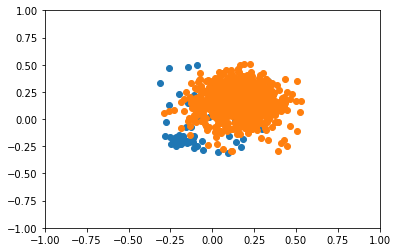

epoch: 8700, train cost_P 0.818654, train cost: 0.904795, test cost: 0.957002, minimum test cost: 0.956202
means of test groups: tensor([[3.8579],
        [2.9037],
        [3.2330],
        [4.3098],
        [3.2292]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 5., 2.])


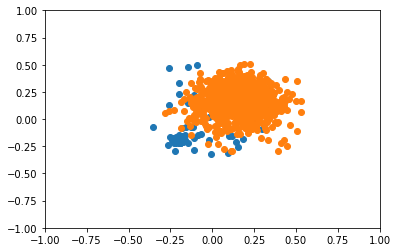

epoch: 8800, train cost_P 0.818512, train cost: 0.904717, test cost: 0.956875, minimum test cost: 0.956202
means of test groups: tensor([[4.0699],
        [3.6799],
        [3.7929],
        [3.2521],
        [3.9106]], device='cuda:0')
ratings of test groups: tensor([1., 4., 5., 4., 4.])


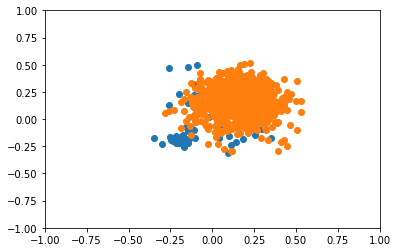

epoch: 8900, train cost_P 0.818384, train cost: 0.904646, test cost: 0.956887, minimum test cost: 0.956202
means of test groups: tensor([[2.9051],
        [3.9879],
        [4.1172],
        [3.1879],
        [3.9839]], device='cuda:0')
ratings of test groups: tensor([1., 5., 4., 2., 3.])


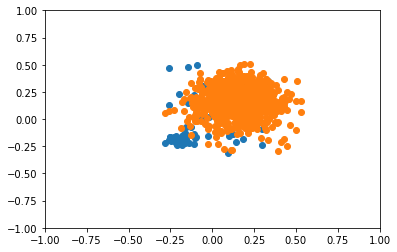

epoch: 9000, train cost_P 0.818294, train cost: 0.904596, test cost: 0.957042, minimum test cost: 0.956202
means of test groups: tensor([[3.1823],
        [2.1110],
        [2.0686],
        [2.2167],
        [2.8013]], device='cuda:0')
ratings of test groups: tensor([5., 1., 2., 4., 3.])


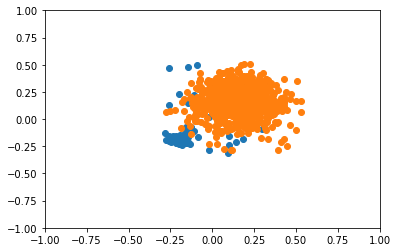

epoch: 9100, train cost_P 0.818180, train cost: 0.904533, test cost: 0.957058, minimum test cost: 0.956202
means of test groups: tensor([[3.8174],
        [3.4961],
        [3.4110],
        [2.9441],
        [3.7227]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 2., 4.])


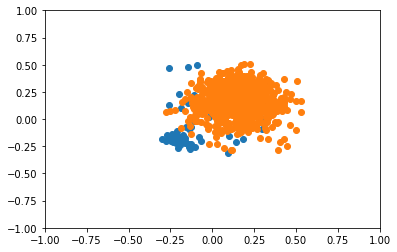

epoch: 9200, train cost_P 0.818103, train cost: 0.904491, test cost: 0.957022, minimum test cost: 0.956202
means of test groups: tensor([[3.5822],
        [2.6441],
        [3.2845],
        [4.3409],
        [2.5917]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 3., 1.])


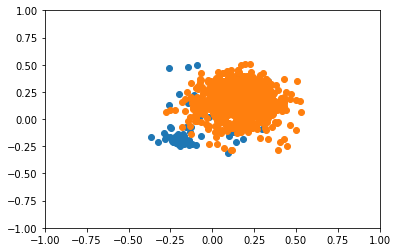

epoch: 9300, train cost_P 0.817987, train cost: 0.904426, test cost: 0.957010, minimum test cost: 0.956202
means of test groups: tensor([[3.0964],
        [3.9885],
        [4.6785],
        [3.2187],
        [3.2715]], device='cuda:0')
ratings of test groups: tensor([2., 3., 5., 2., 3.])


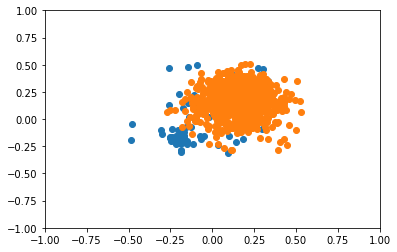

epoch: 9400, train cost_P 0.817936, train cost: 0.904398, test cost: 0.957113, minimum test cost: 0.956202
means of test groups: tensor([[3.5686],
        [3.9205],
        [4.3132],
        [3.5477],
        [3.8788]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 4., 4.])


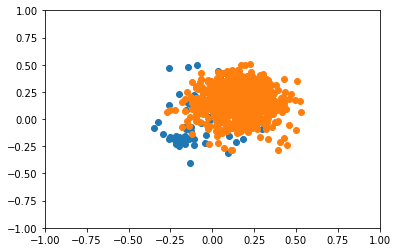

epoch: 9500, train cost_P 0.817876, train cost: 0.904365, test cost: 0.957116, minimum test cost: 0.956202
means of test groups: tensor([[2.8384],
        [4.0102],
        [4.3725],
        [3.0842],
        [5.5281]], device='cuda:0')
ratings of test groups: tensor([2., 4., 3., 2., 5.])


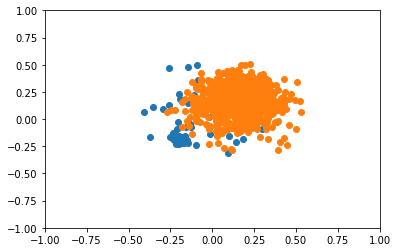

epoch: 9600, train cost_P 0.817743, train cost: 0.904291, test cost: 0.957031, minimum test cost: 0.956202
means of test groups: tensor([[3.9831],
        [2.8095],
        [3.1638],
        [3.6240],
        [1.4723]], device='cuda:0')
ratings of test groups: tensor([1., 4., 3., 5., 1.])


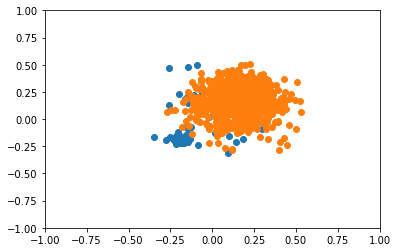

epoch: 9700, train cost_P 0.817659, train cost: 0.904245, test cost: 0.957105, minimum test cost: 0.956202
means of test groups: tensor([[3.1039],
        [4.2206],
        [3.6369],
        [3.8047],
        [3.1465]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 3., 3.])


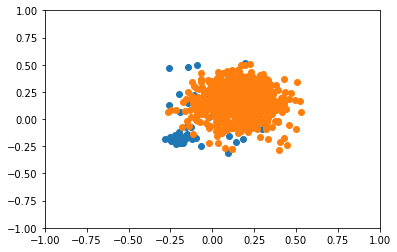

epoch: 9800, train cost_P 0.817582, train cost: 0.904203, test cost: 0.957205, minimum test cost: 0.956202
means of test groups: tensor([[3.8315],
        [4.2189],
        [2.8188],
        [3.3189],
        [4.1995]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 4., 4.])


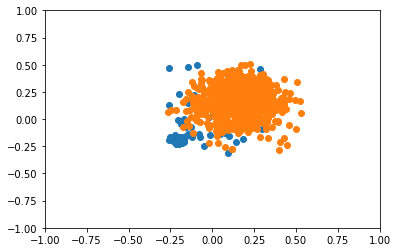

epoch: 9900, train cost_P 0.817501, train cost: 0.904158, test cost: 0.957200, minimum test cost: 0.956202
means of test groups: tensor([[4.2656],
        [3.7139],
        [2.2783],
        [2.7579],
        [3.9834]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 3., 5.])


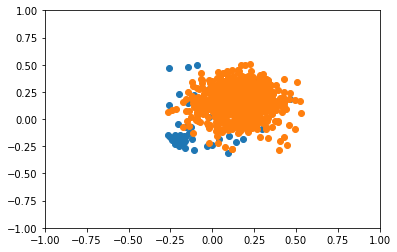

epoch: 10000, train cost_P 0.817398, train cost: 0.904101, test cost: 0.957164, minimum test cost: 0.956202
means of test groups: tensor([[3.8286],
        [3.3689],
        [1.1288],
        [4.1731],
        [4.2326]], device='cuda:0')
ratings of test groups: tensor([3., 2., 2., 5., 4.])


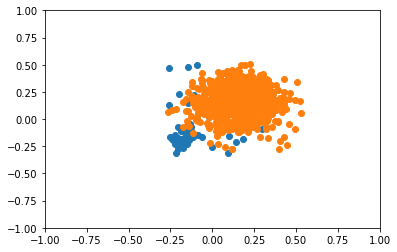

epoch: 10100, train cost_P 0.817363, train cost: 0.904081, test cost: 0.957241, minimum test cost: 0.956202
means of test groups: tensor([[2.3680],
        [2.5153],
        [4.0417],
        [3.1320],
        [3.3694]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 3., 5.])


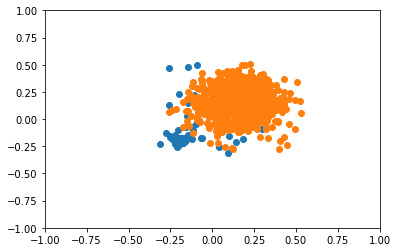

epoch: 10200, train cost_P 0.817337, train cost: 0.904067, test cost: 0.957256, minimum test cost: 0.956202
means of test groups: tensor([[3.3927],
        [4.8707],
        [4.5783],
        [3.4488],
        [2.6811]], device='cuda:0')
ratings of test groups: tensor([2., 5., 5., 3., 3.])


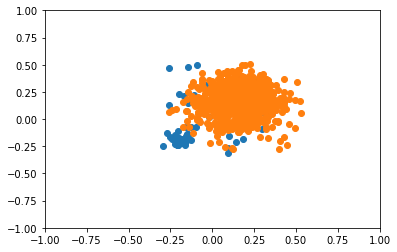

epoch: 10300, train cost_P 0.817234, train cost: 0.904010, test cost: 0.957226, minimum test cost: 0.956202
means of test groups: tensor([[3.2936],
        [2.9559],
        [3.5647],
        [2.6802],
        [3.5304]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 3., 3.])


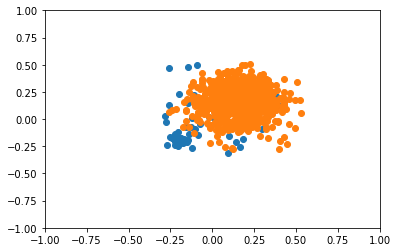

epoch: 10400, train cost_P 0.817123, train cost: 0.903949, test cost: 0.957293, minimum test cost: 0.956202
means of test groups: tensor([[2.9729],
        [2.6968],
        [3.9828],
        [3.1048],
        [3.6782]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 3., 4.])


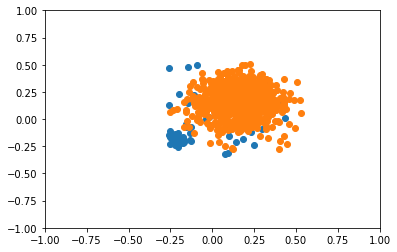

epoch: 10500, train cost_P 0.817059, train cost: 0.903913, test cost: 0.957357, minimum test cost: 0.956202
means of test groups: tensor([[3.1516],
        [3.6592],
        [3.3802],
        [3.6918],
        [3.7940]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 3., 4.])


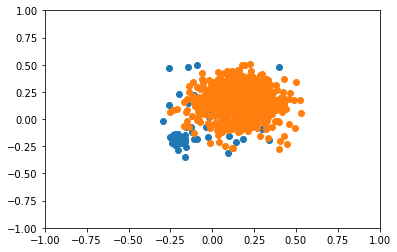

epoch: 10600, train cost_P 0.817039, train cost: 0.903902, test cost: 0.957368, minimum test cost: 0.956202
means of test groups: tensor([[4.0454],
        [4.0727],
        [2.3883],
        [4.3633],
        [2.8781]], device='cuda:0')
ratings of test groups: tensor([5., 5., 4., 4., 4.])


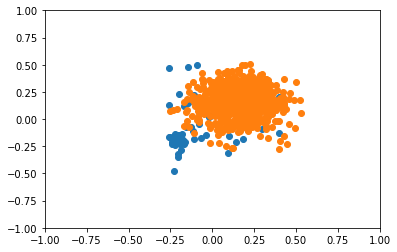

epoch: 10700, train cost_P 0.816921, train cost: 0.903837, test cost: 0.957343, minimum test cost: 0.956202
means of test groups: tensor([[3.0399],
        [3.5740],
        [3.4506],
        [3.4156],
        [3.5952]], device='cuda:0')
ratings of test groups: tensor([1., 1., 3., 3., 4.])


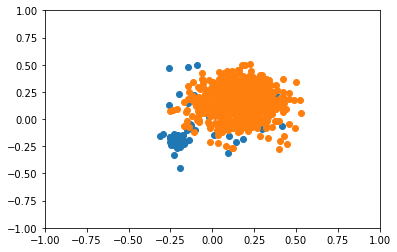

epoch: 10800, train cost_P 0.816861, train cost: 0.903804, test cost: 0.957365, minimum test cost: 0.956202
means of test groups: tensor([[3.1309],
        [3.7829],
        [4.0612],
        [3.1348],
        [3.6132]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 3., 4.])


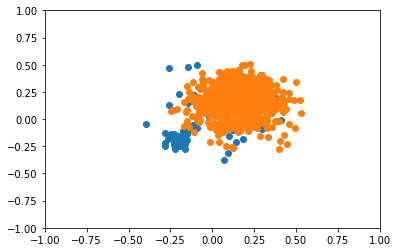

epoch: 10900, train cost_P 0.816874, train cost: 0.903811, test cost: 0.957446, minimum test cost: 0.956202
means of test groups: tensor([[3.4474],
        [4.0369],
        [4.7393],
        [4.4480],
        [4.1628]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 5., 5.])


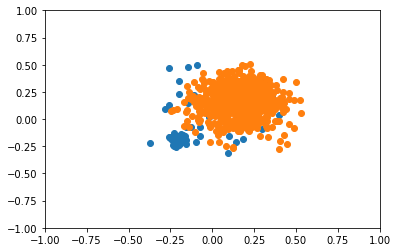

epoch: 11000, train cost_P 0.816858, train cost: 0.903802, test cost: 0.957491, minimum test cost: 0.956202
means of test groups: tensor([[4.7550],
        [4.2111],
        [3.9130],
        [3.7051],
        [3.2279]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 4.])


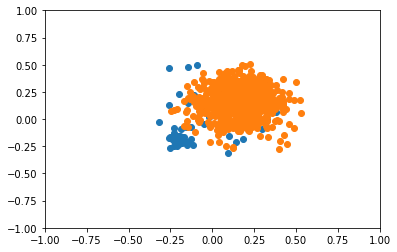

epoch: 11100, train cost_P 0.816699, train cost: 0.903714, test cost: 0.957474, minimum test cost: 0.956202
means of test groups: tensor([[3.7547],
        [3.6816],
        [3.0202],
        [3.7232],
        [3.7510]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 4., 4.])


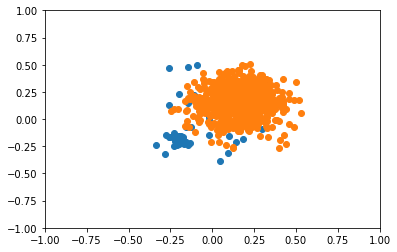

epoch: 11200, train cost_P 0.816613, train cost: 0.903666, test cost: 0.957502, minimum test cost: 0.956202
means of test groups: tensor([[3.0128],
        [4.5304],
        [2.7862],
        [3.1794],
        [4.7223]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 2., 4.])


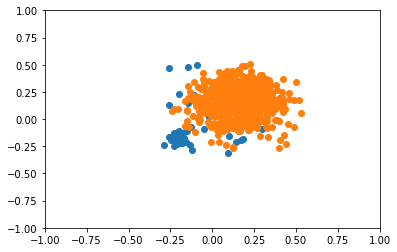

epoch: 11300, train cost_P 0.816619, train cost: 0.903670, test cost: 0.957538, minimum test cost: 0.956202
means of test groups: tensor([[3.8737],
        [2.5902],
        [2.6068],
        [3.6479],
        [4.0390]], device='cuda:0')
ratings of test groups: tensor([5., 1., 5., 4., 3.])


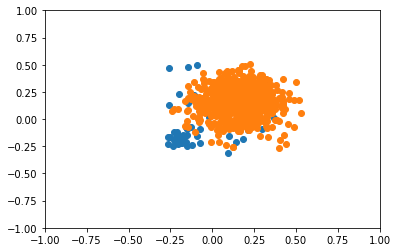

epoch: 11400, train cost_P 0.816602, train cost: 0.903660, test cost: 0.957553, minimum test cost: 0.956202
means of test groups: tensor([[2.4432],
        [3.3705],
        [3.5265],
        [3.2792],
        [2.4363]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 3., 2.])


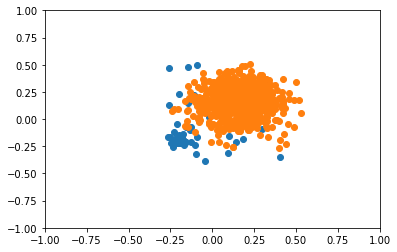

epoch: 11500, train cost_P 0.816471, train cost: 0.903588, test cost: 0.957538, minimum test cost: 0.956202
means of test groups: tensor([[2.7087],
        [2.8230],
        [3.3088],
        [3.0316],
        [3.2061]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 4., 3.])


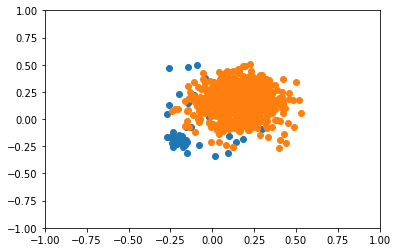

epoch: 11600, train cost_P 0.816437, train cost: 0.903569, test cost: 0.957587, minimum test cost: 0.956202
means of test groups: tensor([[3.1889],
        [2.2779],
        [4.0517],
        [2.9100],
        [3.3922]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 2., 2.])


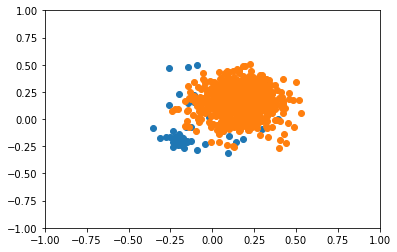

epoch: 11700, train cost_P 0.816500, train cost: 0.903604, test cost: 0.957714, minimum test cost: 0.956202
means of test groups: tensor([[3.6636],
        [3.8508],
        [4.2744],
        [2.4937],
        [3.7104]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 2., 5.])


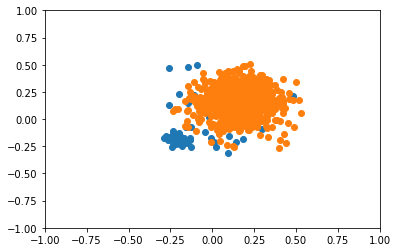

epoch: 11800, train cost_P 0.816422, train cost: 0.903560, test cost: 0.957745, minimum test cost: 0.956202
means of test groups: tensor([[3.7162],
        [3.6920],
        [2.2418],
        [4.5511],
        [3.6409]], device='cuda:0')
ratings of test groups: tensor([4., 5., 1., 5., 5.])


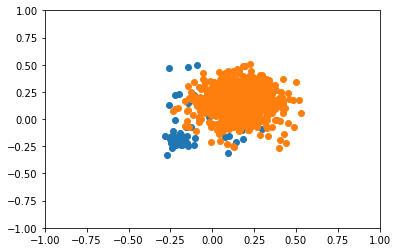

epoch: 11900, train cost_P 0.816252, train cost: 0.903466, test cost: 0.957660, minimum test cost: 0.956202
means of test groups: tensor([[3.7255],
        [3.9990],
        [3.2775],
        [3.5756],
        [2.2671]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 4., 2.])


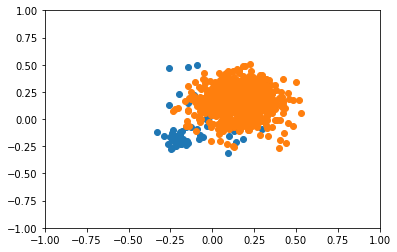

epoch: 12000, train cost_P 0.816216, train cost: 0.903447, test cost: 0.957658, minimum test cost: 0.956202
means of test groups: tensor([[3.9725],
        [3.8338],
        [2.9251],
        [3.2812],
        [2.7353]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 2., 5.])


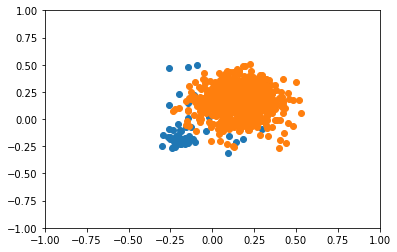

epoch: 12100, train cost_P 0.816311, train cost: 0.903500, test cost: 0.957784, minimum test cost: 0.956202
means of test groups: tensor([[3.1121],
        [3.8769],
        [2.9942],
        [4.6735],
        [3.5467]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 5., 4.])


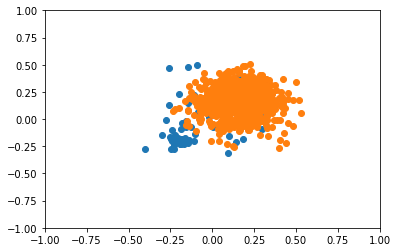

epoch: 12200, train cost_P 0.816233, train cost: 0.903456, test cost: 0.957757, minimum test cost: 0.956202
means of test groups: tensor([[3.8765],
        [3.4928],
        [3.6927],
        [2.6951],
        [2.6187]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 3.])


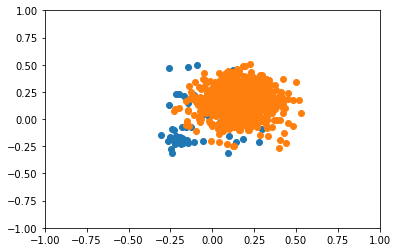

epoch: 12300, train cost_P 0.816105, train cost: 0.903385, test cost: 0.957750, minimum test cost: 0.956202
means of test groups: tensor([[4.5317],
        [3.4921],
        [2.9067],
        [3.7296],
        [4.1291]], device='cuda:0')
ratings of test groups: tensor([3., 5., 2., 2., 4.])


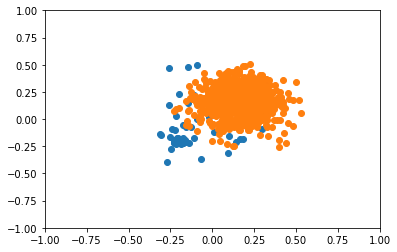

epoch: 12400, train cost_P 0.816063, train cost: 0.903362, test cost: 0.957827, minimum test cost: 0.956202
means of test groups: tensor([[3.5314],
        [2.9067],
        [3.7069],
        [3.4602],
        [2.5593]], device='cuda:0')
ratings of test groups: tensor([5., 3., 3., 4., 4.])


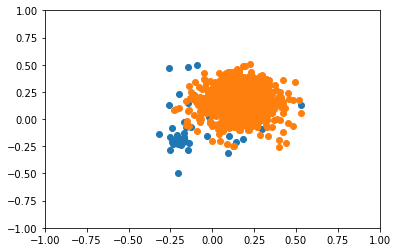

epoch: 12500, train cost_P 0.816121, train cost: 0.903394, test cost: 0.957946, minimum test cost: 0.956202
means of test groups: tensor([[3.9192],
        [3.5486],
        [3.0503],
        [2.2362],
        [3.1484]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 2., 3.])


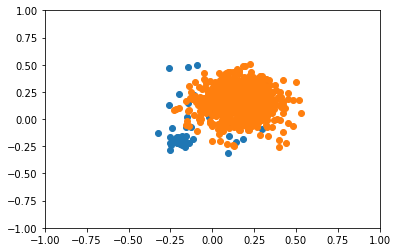

epoch: 12600, train cost_P 0.816114, train cost: 0.903390, test cost: 0.957967, minimum test cost: 0.956202
means of test groups: tensor([[2.6341],
        [3.9900],
        [3.5210],
        [3.4386],
        [4.1486]], device='cuda:0')
ratings of test groups: tensor([1., 4., 3., 5., 3.])


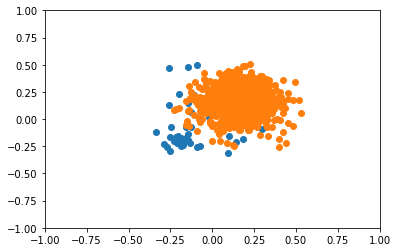

epoch: 12700, train cost_P 0.815927, train cost: 0.903287, test cost: 0.957853, minimum test cost: 0.956202
means of test groups: tensor([[3.5999],
        [4.4585],
        [4.1764],
        [2.5162],
        [4.2321]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 3., 5.])


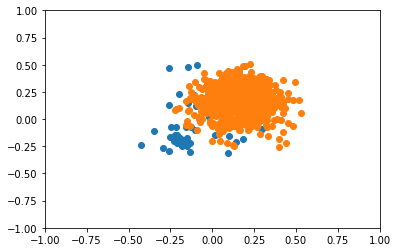

epoch: 12800, train cost_P 0.815895, train cost: 0.903269, test cost: 0.957838, minimum test cost: 0.956202
means of test groups: tensor([[3.7715],
        [1.9152],
        [5.2105],
        [3.2671],
        [3.3558]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 3., 3.])


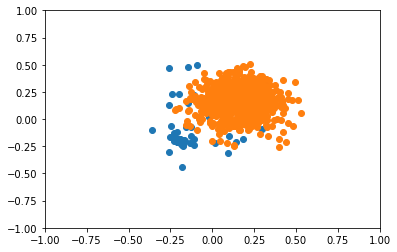

epoch: 12900, train cost_P 0.815903, train cost: 0.903273, test cost: 0.957879, minimum test cost: 0.956202
means of test groups: tensor([[4.0932],
        [4.2400],
        [4.2008],
        [3.2393],
        [3.9043]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 3.])


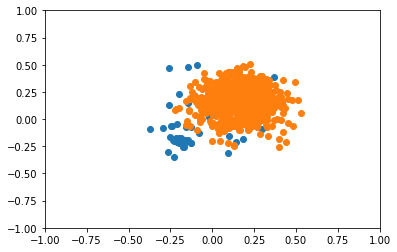

epoch: 13000, train cost_P 0.816205, train cost: 0.903441, test cost: 0.958152, minimum test cost: 0.956202
means of test groups: tensor([[3.1766],
        [2.7395],
        [3.6029],
        [1.8571],
        [3.7968]], device='cuda:0')
ratings of test groups: tensor([3., 2., 2., 1., 5.])


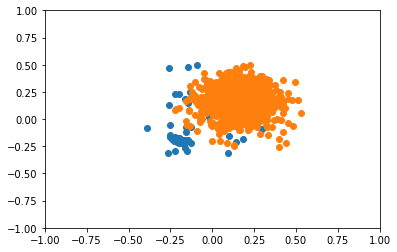

epoch: 13100, train cost_P 0.815796, train cost: 0.903214, test cost: 0.957995, minimum test cost: 0.956202
means of test groups: tensor([[3.7991],
        [5.0353],
        [3.6003],
        [3.6657],
        [3.7747]], device='cuda:0')
ratings of test groups: tensor([5., 5., 3., 3., 4.])


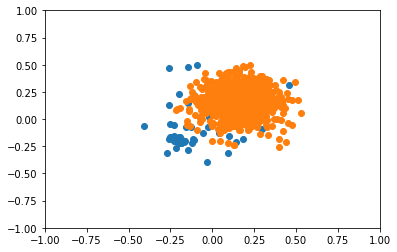

epoch: 13200, train cost_P 0.815733, train cost: 0.903179, test cost: 0.957995, minimum test cost: 0.956202
means of test groups: tensor([[4.6544],
        [4.1567],
        [3.9035],
        [3.4123],
        [3.7233]], device='cuda:0')
ratings of test groups: tensor([5., 4., 4., 2., 4.])


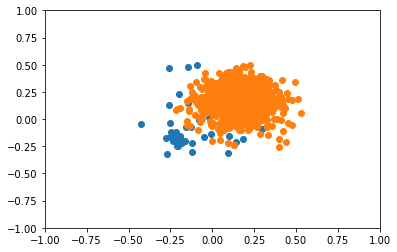

epoch: 13300, train cost_P 0.815703, train cost: 0.903163, test cost: 0.958030, minimum test cost: 0.956202
means of test groups: tensor([[3.6453],
        [4.4643],
        [3.0297],
        [3.8418],
        [4.7897]], device='cuda:0')
ratings of test groups: tensor([5., 5., 2., 4., 4.])


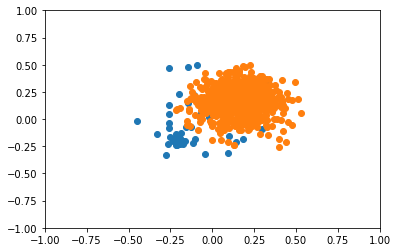

epoch: 13400, train cost_P 0.815715, train cost: 0.903169, test cost: 0.958102, minimum test cost: 0.956202
means of test groups: tensor([[3.0920],
        [3.1462],
        [3.7355],
        [2.5753],
        [3.1400]], device='cuda:0')
ratings of test groups: tensor([2., 4., 4., 4., 4.])


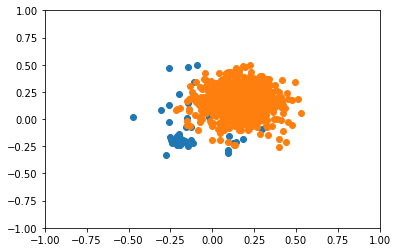

epoch: 13500, train cost_P 0.816139, train cost: 0.903404, test cost: 0.958365, minimum test cost: 0.956202
means of test groups: tensor([[3.8771],
        [3.3711],
        [3.4968],
        [4.0622],
        [3.2896]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 4., 4.])


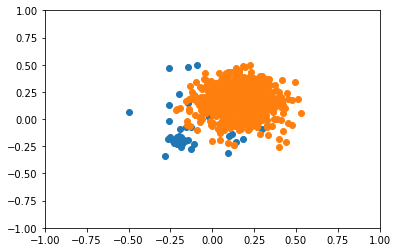

epoch: 13600, train cost_P 0.815643, train cost: 0.903130, test cost: 0.958038, minimum test cost: 0.956202
means of test groups: tensor([[3.3342],
        [2.4040],
        [3.8319],
        [3.8493],
        [2.6730]], device='cuda:0')
ratings of test groups: tensor([2., 3., 4., 5., 3.])


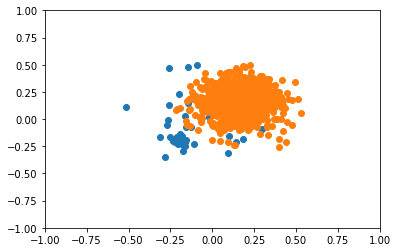

epoch: 13700, train cost_P 0.815600, train cost: 0.903106, test cost: 0.958046, minimum test cost: 0.956202
means of test groups: tensor([[2.6059],
        [3.6404],
        [3.5952],
        [4.1695],
        [2.3801]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 3., 4.])


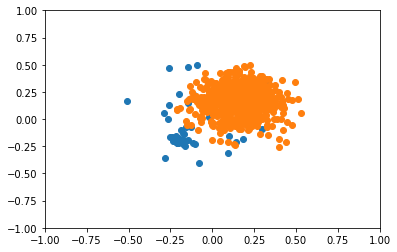

epoch: 13800, train cost_P 0.815555, train cost: 0.903081, test cost: 0.958130, minimum test cost: 0.956202
means of test groups: tensor([[1.1240],
        [4.2854],
        [3.7212],
        [3.7482],
        [2.8575]], device='cuda:0')
ratings of test groups: tensor([1., 4., 3., 4., 4.])


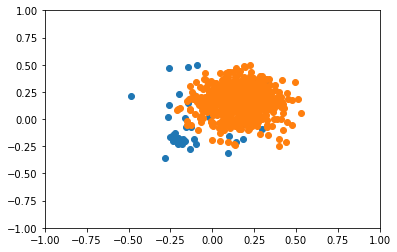

epoch: 13900, train cost_P 0.815529, train cost: 0.903066, test cost: 0.958202, minimum test cost: 0.956202
means of test groups: tensor([[0.8333],
        [3.8323],
        [3.5941],
        [3.7939],
        [3.9601]], device='cuda:0')
ratings of test groups: tensor([1., 3., 4., 3., 5.])


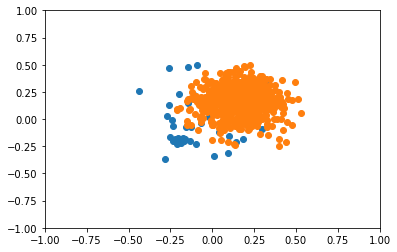

epoch: 14000, train cost_P 0.815698, train cost: 0.903160, test cost: 0.958301, minimum test cost: 0.956202
means of test groups: tensor([[3.5175],
        [4.0803],
        [2.9797],
        [3.5429],
        [3.7319]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 3., 4.])


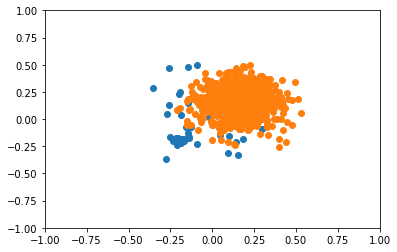

epoch: 14100, train cost_P 0.815515, train cost: 0.903059, test cost: 0.958274, minimum test cost: 0.956202
means of test groups: tensor([[3.7962],
        [3.8851],
        [3.4375],
        [0.4830],
        [3.6230]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 1., 3.])


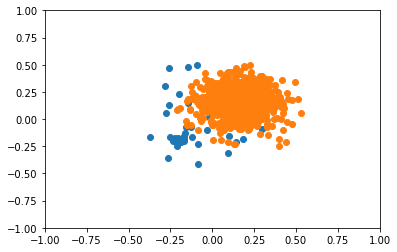

epoch: 14200, train cost_P 0.815453, train cost: 0.903024, test cost: 0.958232, minimum test cost: 0.956202
means of test groups: tensor([[2.5282],
        [3.8698],
        [4.2498],
        [4.2530],
        [4.5508]], device='cuda:0')
ratings of test groups: tensor([1., 1., 5., 4., 5.])


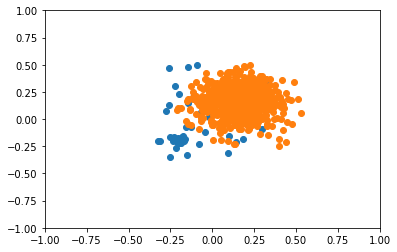

epoch: 14300, train cost_P 0.815432, train cost: 0.903013, test cost: 0.958255, minimum test cost: 0.956202
means of test groups: tensor([[3.0905],
        [3.8666],
        [4.0883],
        [3.9408],
        [3.6137]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 2.])


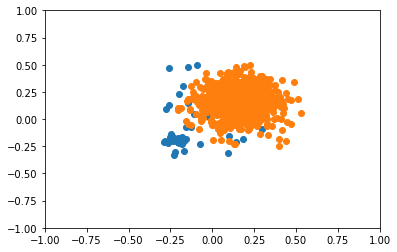

epoch: 14400, train cost_P 0.815420, train cost: 0.903006, test cost: 0.958296, minimum test cost: 0.956202
means of test groups: tensor([[3.6404],
        [4.1118],
        [4.0053],
        [4.2196],
        [4.6174]], device='cuda:0')
ratings of test groups: tensor([1., 5., 4., 5., 4.])


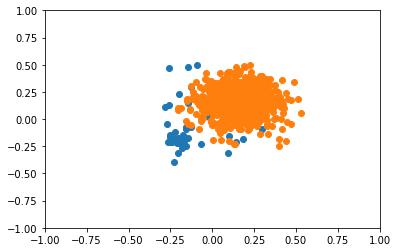

epoch: 14500, train cost_P 0.815419, train cost: 0.903006, test cost: 0.958294, minimum test cost: 0.956202
means of test groups: tensor([[4.2141],
        [3.4155],
        [4.1866],
        [3.4404],
        [4.5181]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 4., 4.])


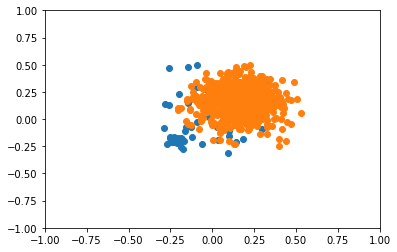

epoch: 14600, train cost_P 0.815782, train cost: 0.903207, test cost: 0.958615, minimum test cost: 0.956202
means of test groups: tensor([[3.4693],
        [3.8380],
        [3.3594],
        [3.3123],
        [3.2002]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 3., 3.])


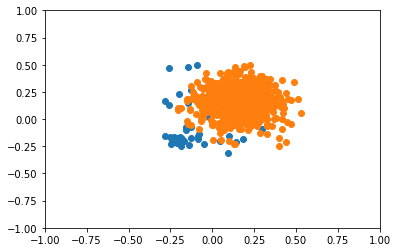

epoch: 14700, train cost_P 0.815298, train cost: 0.902939, test cost: 0.958353, minimum test cost: 0.956202
means of test groups: tensor([[3.4046],
        [4.0748],
        [3.0541],
        [3.9639],
        [2.7521]], device='cuda:0')
ratings of test groups: tensor([2., 5., 3., 4., 3.])


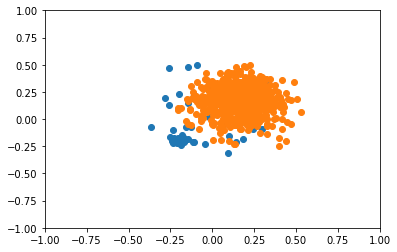

epoch: 14800, train cost_P 0.815281, train cost: 0.902929, test cost: 0.958380, minimum test cost: 0.956202
means of test groups: tensor([[3.2229],
        [3.6088],
        [3.4301],
        [3.4929],
        [4.2405]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 4.])


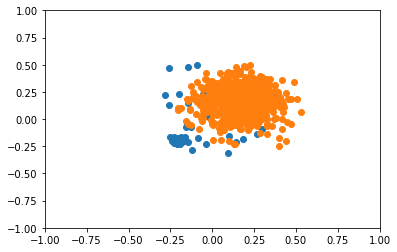

epoch: 14900, train cost_P 0.815279, train cost: 0.902928, test cost: 0.958420, minimum test cost: 0.956202
means of test groups: tensor([[3.8853],
        [4.0425],
        [3.2472],
        [3.9925],
        [3.4348]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 5., 5.])


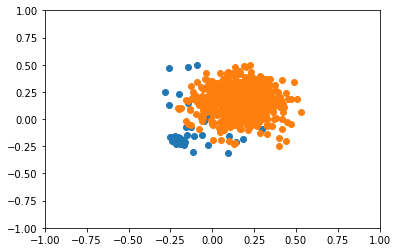

epoch: 15000, train cost_P 0.815285, train cost: 0.902931, test cost: 0.958420, minimum test cost: 0.956202
means of test groups: tensor([[3.1918],
        [3.4723],
        [4.2574],
        [3.0943],
        [2.9159]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 1., 2.])


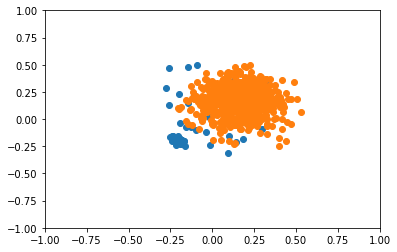

epoch: 15100, train cost_P 0.815516, train cost: 0.903059, test cost: 0.958660, minimum test cost: 0.956202
means of test groups: tensor([[3.5389],
        [3.3745],
        [4.0975],
        [3.9566],
        [3.9320]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 4., 4.])


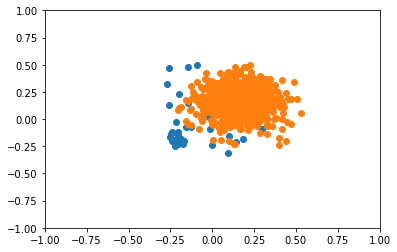

epoch: 15200, train cost_P 0.815196, train cost: 0.902882, test cost: 0.958454, minimum test cost: 0.956202
means of test groups: tensor([[3.4753],
        [3.6902],
        [3.1146],
        [3.8799],
        [1.8816]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 4., 1.])


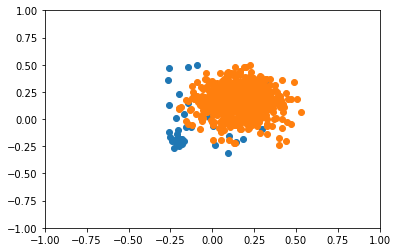

epoch: 15300, train cost_P 0.815161, train cost: 0.902862, test cost: 0.958481, minimum test cost: 0.956202
means of test groups: tensor([[2.6658],
        [4.0556],
        [3.1335],
        [4.2856],
        [4.2283]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 5., 3.])


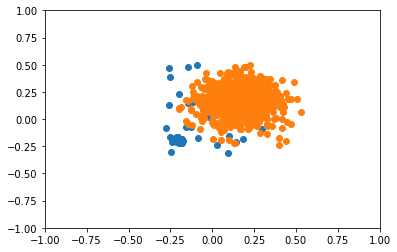

epoch: 15400, train cost_P 0.815137, train cost: 0.902850, test cost: 0.958505, minimum test cost: 0.956202
means of test groups: tensor([[2.8093],
        [4.2361],
        [3.1029],
        [2.9850],
        [4.3327]], device='cuda:0')
ratings of test groups: tensor([2., 5., 5., 4., 4.])


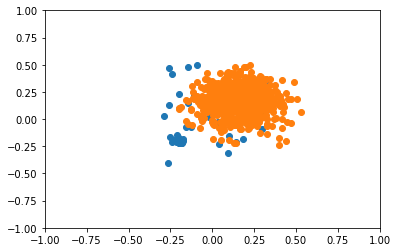

epoch: 15500, train cost_P 0.815149, train cost: 0.902856, test cost: 0.958547, minimum test cost: 0.956202
means of test groups: tensor([[4.3575],
        [3.7954],
        [3.9818],
        [3.5056],
        [4.4931]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 5., 5.])


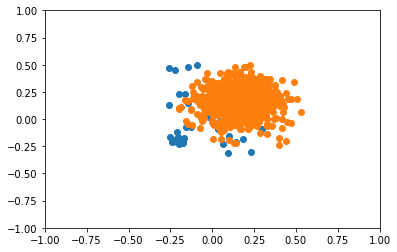

epoch: 15600, train cost_P 0.815280, train cost: 0.902928, test cost: 0.958768, minimum test cost: 0.956202
means of test groups: tensor([[3.4857],
        [3.6497],
        [3.7406],
        [4.1992],
        [3.3714]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 5., 4.])


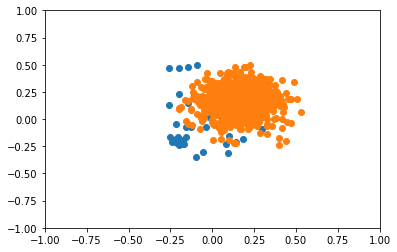

epoch: 15700, train cost_P 0.815158, train cost: 0.902861, test cost: 0.958654, minimum test cost: 0.956202
means of test groups: tensor([[3.5574],
        [4.3225],
        [3.1381],
        [3.4506],
        [4.0850]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 3., 5.])


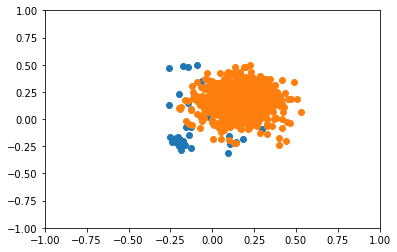

epoch: 15800, train cost_P 0.815058, train cost: 0.902805, test cost: 0.958540, minimum test cost: 0.956202
means of test groups: tensor([[4.4774],
        [2.8118],
        [3.5774],
        [4.1640],
        [4.0014]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 4., 4.])


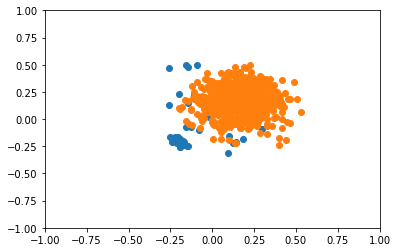

epoch: 15900, train cost_P 0.815026, train cost: 0.902788, test cost: 0.958538, minimum test cost: 0.956202
means of test groups: tensor([[2.2835],
        [4.0642],
        [3.5427],
        [4.0841],
        [3.6557]], device='cuda:0')
ratings of test groups: tensor([1., 5., 3., 5., 2.])


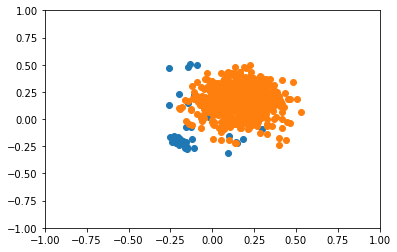

epoch: 16000, train cost_P 0.815029, train cost: 0.902790, test cost: 0.958630, minimum test cost: 0.956202
means of test groups: tensor([[3.4899],
        [4.8364],
        [3.0365],
        [3.0351],
        [3.6235]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 3., 4.])


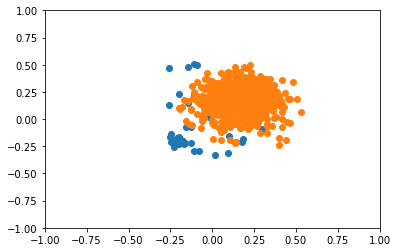

epoch: 16100, train cost_P 0.815144, train cost: 0.902853, test cost: 0.958861, minimum test cost: 0.956202
means of test groups: tensor([[3.7564],
        [2.7458],
        [3.6462],
        [4.4086],
        [3.3465]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 2.])


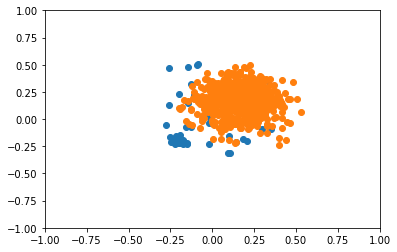

epoch: 16200, train cost_P 0.815118, train cost: 0.902839, test cost: 0.958809, minimum test cost: 0.956202
means of test groups: tensor([[4.2442],
        [3.5168],
        [3.8435],
        [2.9045],
        [3.2912]], device='cuda:0')
ratings of test groups: tensor([5., 4., 4., 3., 3.])


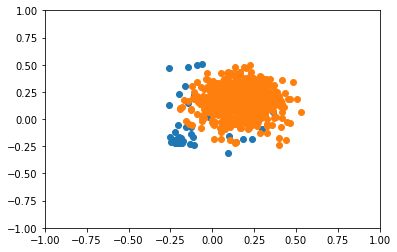

epoch: 16300, train cost_P 0.814960, train cost: 0.902751, test cost: 0.958720, minimum test cost: 0.956202
means of test groups: tensor([[3.6379],
        [3.5575],
        [3.3467],
        [2.2079],
        [3.9908]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 2., 2.])


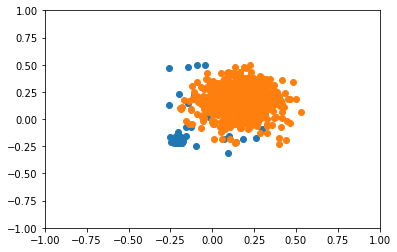

epoch: 16400, train cost_P 0.814935, train cost: 0.902737, test cost: 0.958731, minimum test cost: 0.956202
means of test groups: tensor([[4.0646],
        [3.4742],
        [0.8406],
        [3.0916],
        [4.0640]], device='cuda:0')
ratings of test groups: tensor([4., 5., 1., 4., 5.])


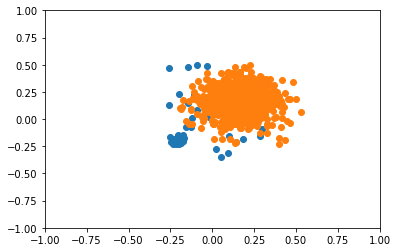

epoch: 16500, train cost_P 0.814939, train cost: 0.902740, test cost: 0.958755, minimum test cost: 0.956202
means of test groups: tensor([[2.3262],
        [3.1308],
        [4.0845],
        [2.2369],
        [2.5098]], device='cuda:0')
ratings of test groups: tensor([1., 3., 4., 1., 3.])


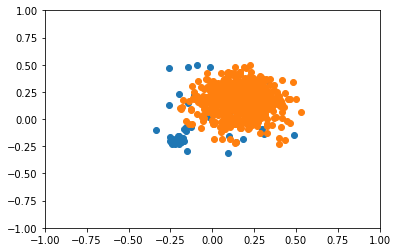

epoch: 16600, train cost_P 0.815057, train cost: 0.902805, test cost: 0.958894, minimum test cost: 0.956202
means of test groups: tensor([[3.2294],
        [4.2683],
        [4.1489],
        [3.2968],
        [3.7117]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 3., 4.])


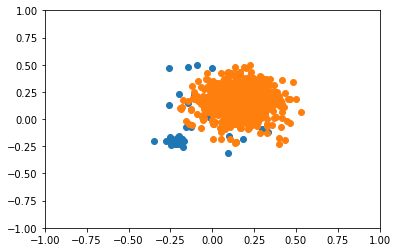

epoch: 16700, train cost_P 0.814962, train cost: 0.902752, test cost: 0.958826, minimum test cost: 0.956202
means of test groups: tensor([[3.6044],
        [3.5518],
        [3.8465],
        [3.0727],
        [3.6735]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 2., 4.])


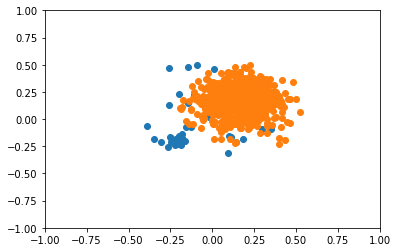

epoch: 16800, train cost_P 0.814866, train cost: 0.902699, test cost: 0.958800, minimum test cost: 0.956202
means of test groups: tensor([[3.4312],
        [3.7230],
        [3.4510],
        [3.5871],
        [4.2034]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 5., 5.])


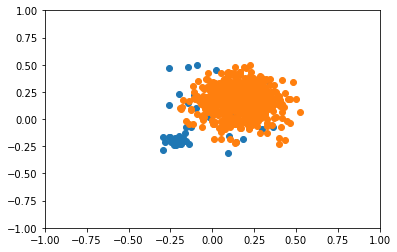

epoch: 16900, train cost_P 0.814858, train cost: 0.902695, test cost: 0.958858, minimum test cost: 0.956202
means of test groups: tensor([[3.2898],
        [3.7303],
        [4.2144],
        [4.0639],
        [3.6068]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 5., 3.])


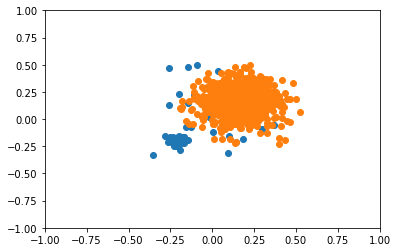

epoch: 17000, train cost_P 0.814886, train cost: 0.902710, test cost: 0.958953, minimum test cost: 0.956202
means of test groups: tensor([[2.6310],
        [3.7294],
        [3.5438],
        [2.4753],
        [4.1525]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 2., 3.])


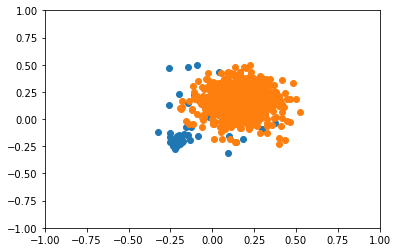

epoch: 17100, train cost_P 0.815036, train cost: 0.902793, test cost: 0.959080, minimum test cost: 0.956202
means of test groups: tensor([[2.2539],
        [3.2946],
        [3.6663],
        [2.0042],
        [4.4175]], device='cuda:0')
ratings of test groups: tensor([3., 1., 1., 3., 5.])


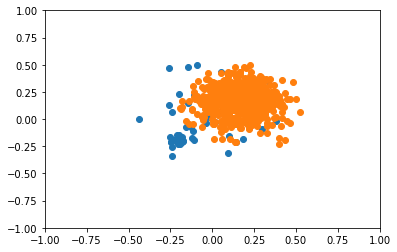

epoch: 17200, train cost_P 0.814810, train cost: 0.902668, test cost: 0.958922, minimum test cost: 0.956202
means of test groups: tensor([[3.1431],
        [4.3353],
        [2.7681],
        [4.2493],
        [2.7238]], device='cuda:0')
ratings of test groups: tensor([2., 5., 2., 3., 3.])


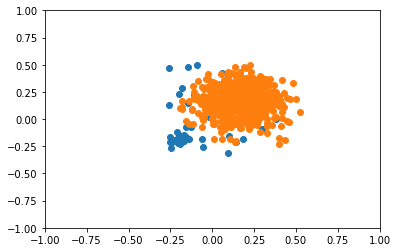

epoch: 17300, train cost_P 0.814770, train cost: 0.902646, test cost: 0.958889, minimum test cost: 0.956202
means of test groups: tensor([[4.0332],
        [3.9942],
        [3.3504],
        [3.1140],
        [3.8374]], device='cuda:0')
ratings of test groups: tensor([4., 5., 5., 4., 5.])


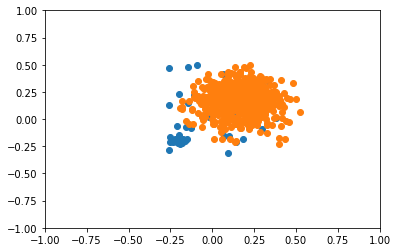

epoch: 17400, train cost_P 0.814777, train cost: 0.902650, test cost: 0.958930, minimum test cost: 0.956202
means of test groups: tensor([[3.0258],
        [3.5942],
        [3.6943],
        [3.9357],
        [3.6508]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 5., 4.])


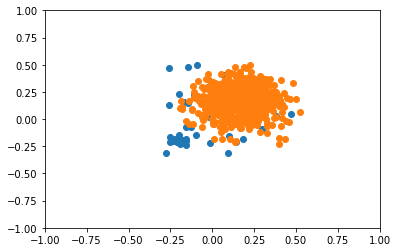

epoch: 17500, train cost_P 0.814822, train cost: 0.902675, test cost: 0.959014, minimum test cost: 0.956202
means of test groups: tensor([[3.9840],
        [3.8193],
        [3.8810],
        [3.0510],
        [3.9631]], device='cuda:0')
ratings of test groups: tensor([5., 5., 4., 3., 5.])


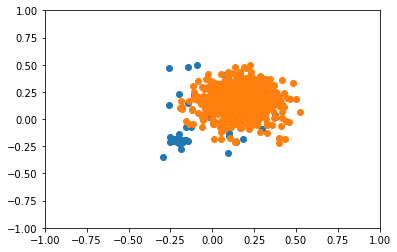

epoch: 17600, train cost_P 0.815033, train cost: 0.902792, test cost: 0.959181, minimum test cost: 0.956202
means of test groups: tensor([[3.9811],
        [4.3412],
        [4.2437],
        [4.3223],
        [3.4459]], device='cuda:0')
ratings of test groups: tensor([4., 2., 5., 5., 4.])


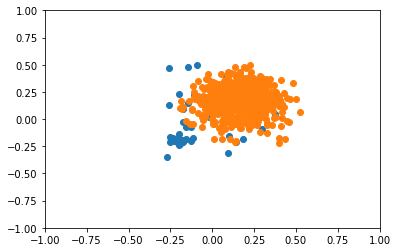

epoch: 17700, train cost_P 0.814720, train cost: 0.902618, test cost: 0.959029, minimum test cost: 0.956202
means of test groups: tensor([[4.5042],
        [3.4622],
        [5.2182],
        [2.8879],
        [2.9552]], device='cuda:0')
ratings of test groups: tensor([5., 3., 5., 2., 1.])


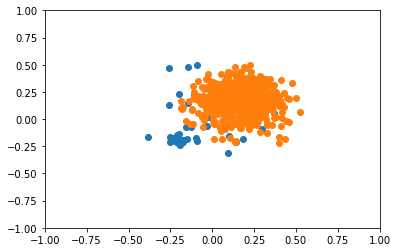

epoch: 17800, train cost_P 0.814702, train cost: 0.902608, test cost: 0.959051, minimum test cost: 0.956202
means of test groups: tensor([[3.5578],
        [3.7111],
        [3.0523],
        [2.5631],
        [3.7710]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 2., 4.])


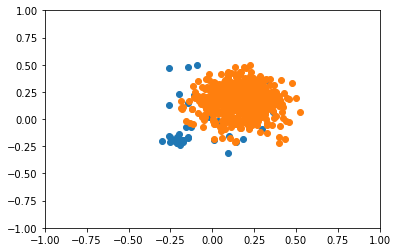

epoch: 17900, train cost_P 0.814709, train cost: 0.902612, test cost: 0.959103, minimum test cost: 0.956202
means of test groups: tensor([[3.9652],
        [3.6750],
        [3.6371],
        [3.8222],
        [3.8481]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 4., 4.])


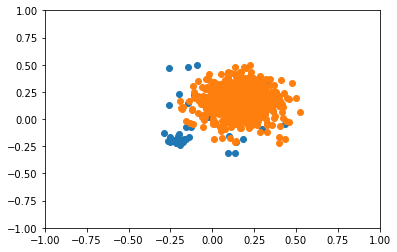

epoch: 18000, train cost_P 0.814790, train cost: 0.902657, test cost: 0.959184, minimum test cost: 0.956202
means of test groups: tensor([[2.9318],
        [3.0627],
        [3.0583],
        [4.0630],
        [4.1124]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 4., 4.])


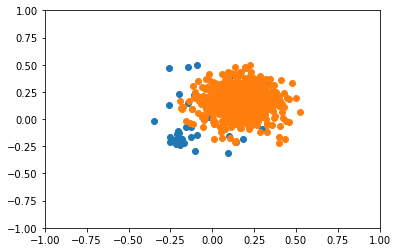

epoch: 18100, train cost_P 0.814813, train cost: 0.902670, test cost: 0.959219, minimum test cost: 0.956202
means of test groups: tensor([[3.5624],
        [4.5375],
        [4.6738],
        [2.9826],
        [3.0326]], device='cuda:0')
ratings of test groups: tensor([4., 5., 5., 3., 5.])


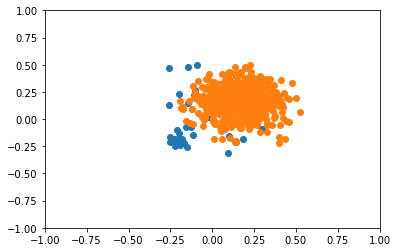

epoch: 18200, train cost_P 0.814649, train cost: 0.902579, test cost: 0.959093, minimum test cost: 0.956202
means of test groups: tensor([[2.4395],
        [2.9531],
        [3.8535],
        [4.1301],
        [4.1549]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 5., 5.])


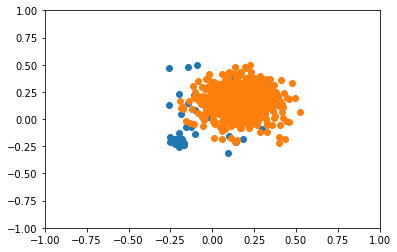

epoch: 18300, train cost_P 0.814638, train cost: 0.902573, test cost: 0.959100, minimum test cost: 0.956202
means of test groups: tensor([[4.1856],
        [3.6427],
        [3.7102],
        [3.9713],
        [3.7518]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 2.])


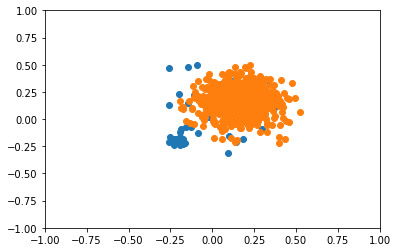

epoch: 18400, train cost_P 0.814660, train cost: 0.902585, test cost: 0.959192, minimum test cost: 0.956202
means of test groups: tensor([[3.5294],
        [4.0642],
        [3.8193],
        [3.7324],
        [3.6849]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 4.])


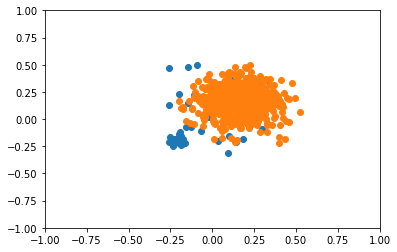

epoch: 18500, train cost_P 0.814834, train cost: 0.902681, test cost: 0.959339, minimum test cost: 0.956202
means of test groups: tensor([[3.0924],
        [3.9236],
        [3.0641],
        [2.4942],
        [2.8173]], device='cuda:0')
ratings of test groups: tensor([4., 4., 1., 4., 1.])


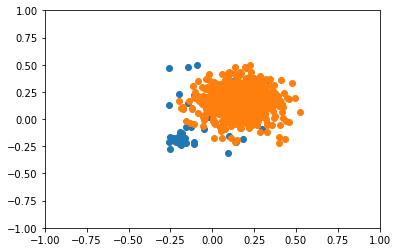

KeyboardInterrupt: 

In [22]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
#optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
#scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)


X = []

Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
    hypothesis_mean_p = (mean + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device) + Q[users].sum(axis = 1) * pnu).unsqueeze(1)
    
    cost_P = F.mse_loss(hypothesis_mean_p, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward(retain_graph = True)
    optimizer_P.step()
    scheduler_P.step()

#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) 
#     hypothesis_mean_q = (mean + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device) + Q[users].sum(axis = 1) * pnu).unsqueeze(1)
    
#     cost_Q = F.mse_loss(hypothesis_mean_q, ratings.unsqueeze(1).to(device))

#     optimizer_Q.zero_grad()
#     cost_Q.backward()
#     optimizer_Q.step()
#     scheduler_Q.step()
    
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
        
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
#        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))                 
        hypo_test_mean = (mean + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device) + Q[users_test].sum(axis = 1) * pnu_test).unsqueeze(1)
    
          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean_p, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)

    if epoch % 100 == 0:
        idx = np.random.choice(9057, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-5)
optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-5)

#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [10,20, 40], gamma = 0.1)
#scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
# scheduler_P = optim.lr_scheduler.ExponentialLR(optimizer_P, gamma = 0.99)
# scheduler_Q = optim.lr_scheduler.ExponentialLR(optimizer_Q, gamma = 0.99)
# scheduler_P = optim.lr_scheduler.ReduceLROnPlateau(optimizer_P, threshold = 1, patience = 1, mode = 'min')
# scheduler_Q = optim.lr_scheduler.ReduceLROnPlateau(optimizer_Q, threshold = 1, patience = 1, mode = 'min')
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)

X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)

    
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    
    scheduler_P.step()
    
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) 
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)

        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
    
    

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    
    
    
    scheduler_Q.step()
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))                 
#        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device).unsqueeze(1)                

          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)
        

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)

    if epoch % 100 == 0:
        idx = np.random.choice(9057, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:
# rank 20 : 0.935448 
# rank 30 : 0.95140 
# rank 15 : 0.93422
# rank 13 : 0.9299      0.9417
# rank 12 : 0.93324
# rank 5 : 0.93482
# rank 25 : 0.93410
# rank 23 : 0.93572
# rank 14 : 0.93860
# rank 10 : 0.93004
# rank 9 : 0.93787
# rank 27 : 0.93910

In [ ]:
X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

In [24]:
len(X), len(Y_test)

(18543, 18543)

In [25]:
X2 = X[:11876]
Y_test2 = Y_test[:11876]

In [26]:
len(hypo_test), len(true_rating)

(186, 186)

In [27]:
len(cost_list), len(cost_test_list)

(18543, 18543)

In [28]:
cost_list2 = cost_list[:11866]
cost_test_list2 = cost_list[:11876]

In [29]:
tr = []
tr_sort = []
for i in range(len(true_rating)):
    trc = true_rating[i].to(device)
    tr.append(trc)
for j in range(len(tr)):
    trs = tr[j].sort(descending = True)[0]
    tr_sort.append(trs)

In [30]:
ndcg_list = []
idcg_list = []
dcg_list = []
for r in range(len(hypo_test)):
    for i in range(5):
        idcg = tr_sort[r][i] / np.log2(i+1 + 1)
        idcg_list.append(idcg)
        sum_idcg = sum(idcg_list)
    for j in range(5):
        dcg = hypo_test[r][j] / np.log2(j+1 + 1)
        dcg_list.append(dcg)
        sum_dcg = sum(dcg_list)
    
    ndcg = sum_dcg / sum_idcg
    ndcg_list.append(ndcg)

In [31]:
nd = []
ct = []
cl = []
for i in range(len(ndcg_list)):
    nds = ndcg_list[i].tolist()
    nd.append(nds)
for j in range(len(cost_test_list2)):
    cts = cost_test_list2[j].tolist()
    ct.append(cts)
for k in range(len(cost_list2)):
    cls = cost_list2[k].tolist()
    cl.append(cls)

In [32]:
nd2 = nd[:119]

In [33]:
import matplotlib.pyplot as plt

In [34]:
epochs = [i for i in range(0, 119)]

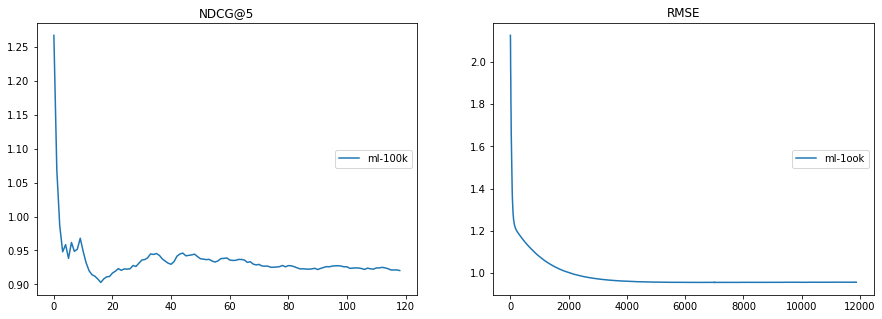

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax = ax.flatten()

ax[0].plot(epochs, nd2, label = 'ml-100k')
ax[0].set_title('NDCG@5')
ax[0].legend(loc = 7)

ax[1].plot(X2, Y_test2, label = 'ml-1ook')
ax[1].set_title('RMSE')
ax[1].legend(loc = 5 )
plt.show()

In [ ]:
len(X2)

In [ ]:
len(cl)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()

ax[0].plot(X2, ct, label = 'ml-100k1')
#ax[0].plot(X2, cl, label = 'ml-100k2')
ax[0].set_title('Loss')
ax[0].legend(loc = 7)

ax[1].plot(epochs, nd2, label = 'ml-100k')
ax[1].set_title('NDCG@5')
ax[1].legend(loc = 7)

ax[2].plot(X2, Y_test2, label = 'ml-1ook')
ax[2].set_title('RMSE')
ax[2].legend(loc = 5 )
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()

ax[0].plot(X, ct, label = 'ml-100k1')
ax[0].plot(X, cl, label = 'ml-100k2')
ax[0].set_title('Loss')
ax[0].legend(loc = 7)

ax[1].plot(epochs, nd, label = 'ml-100k')
ax[1].set_title('NDCG@5')
ax[1].legend(loc = 7)

ax[2].plot(X, Y_test, label = 'ml-1ook')
ax[2].set_title('RMSE')
ax[2].legend(loc = 5 )
plt.show()

In [38]:
import csv

In [36]:
y_epoch = [i for i in range(0, 11876)]

In [39]:
with open("100k_svdplusplus_Y_test2.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([Y_test2])

In [40]:
with open("100k_svdplusplus_ndcg.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(epochs)
        writer.writerows(nd2)

In [41]:
with open("100k_svdplusplus_cost_list.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([cl])

In [42]:
with open("100k_svdplusplus_cost_test_list.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([ct])

In [ ]:
dcg_list = []
for j in range(5):
    dcg = hypo_test[0][j] / np.log2(j+1 + 1)
    dcg_list.append(dcg)
    sum_dcg = sum(dcg_list)

In [ ]:
for j in range(5):
    dcg = hypo_test[0][j] / np.log2(j+1 + 1)
    print(dcg)
    dcg_list.append(dcg)
    sum_dcg = sum(dcg_list)
    print(sum_dcg)

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P] + list(layers_mean.parameters()), lr= 1e-3)
optimizer_Q = torch.optim.Adam([Q] + list(layers_mean.parameters()), lr= 1e-3)



X = []
Y = []
Y_test = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items_test].cuda() + bias_user[users_test].cuda()).unsqueeze(1)                          
          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

### SVD++

In [ ]:
train_1 = pd.read_csv('../ml-100k/ua.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_1 = pd.read_csv('../ml-100k/ua.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
train_2 = pd.read_csv('../ml-100k/ub.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_2 = pd.read_csv('../ml-100k/ub.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])

In [ ]:
train_ratings = train_1.userId.count()
test_ratings = test_1.userId.count()
train_frac = train_ratings/(train_ratings+test_ratings)*100
print(f'Train/test split is: {train_frac, 100-train_frac}')

In [ ]:
R_train1 = pd.pivot_table(train_1, values='rating', index='userId', columns='itemId')
R_test1 = pd.pivot_table(test_1, values='rating', index='userId', columns='itemId')

In [ ]:
R_train1.shape, R_test1.shape

In [ ]:
F = R_train1.copy()

for i in F.index:
    for j in F.columns:
        if np.isnan(F.loc[i,j]) == True:
            F.loc[i,j] = 0
        elif np.isnan(F.loc[i,j]) == False:
            F.loc[i,j] = 1
        else: continue

In [ ]:
F.head()

In [ ]:
print(np.mean(np.nanmean(R_train1, axis=0)))
print(np.mean(np.nanmean(R_train1, axis=1)))

In [ ]:
count = 0
r_sum = 0

for i in R_train1.index:
    for j in R_train1.columns:
        if np.isnan(R_train1.loc[i,j]) == False:
            count += 1
            r_sum += R_train1.loc[i,j]
        else: continue

mu = r_sum/count

In [ ]:
print(f'The global mean/bias for our matrix is: {mu}')


In [ ]:
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

In [ ]:
n = len(R_train1.index)
m = len(R_train1.columns)

In [ ]:
Bu = pd.DataFrame(np.random.rand(n), index= R_train1.index) 
Bi = pd.DataFrame(np.random.rand(m), index= R_train1.columns)

In [ ]:
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
P1 = pd.DataFrame(np.random.rand(n,10), index=R_train1.index)
Q1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)
Y1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)

In [ ]:
P.shape, Q.shape, Y.shape

In [ ]:
P1.shape, Q1.shape, Y1.shape

In [ ]:
train_r1 = np.where(train_r == 0, 0, 1)

In [ ]:
mean = (ratings.sum()/len(ratings)).item()

In [ ]:
train_r2 = torch.from_numpy(train_r1)

In [ ]:
pd.DataFrame(pow(np.sum(F, axis=1), -1/2), index=F.index).shape

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
train_r2.shape

In [ ]:
def SVDplusplus(R, mean, rank, steps, lr, regular, lr_bias, regular_bias):
    
    '''
    R : train_r
    rank = 20
    lr = learning_rate
    '''
    
    rank = rank
    #get the dimentions of R
    n = train_r.shape[0]
    m = train_r.shape[1]
    
    numItems = items.max() + 1
    numUsers = users.max() + 1
    
    #initialize the user, item and global bias
    bias_item = torch.randn(numItems, requires_grad = True)
    bias_user = torch.randn(numUsers, requires_grad = True)
    mean = mean
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
    Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    
    #precalculate implicit feedback metrics
    train_r1 = np.where(train_r == 0, 0, 1)
    train_r2 = torch.from_numpy(train_r1)
    
    y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2)
        
    loss_total = []
    
    for s in range(steps):
        print(f'Iteration {s} started')
        for i in range(R.shape[0]-1):
            for j in range(R.shape[1]-1):
                if np.isnan(R[i,j]) == False:
                    eij = (R[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)))
                    bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
                    bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
                    P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
                    Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)) - regular * Q[j])
                    Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])
                    
        loss_iter = 0
        for i in range(train_r2.shape[0]-1):
            for j in range(train_r2.shape[1]-1):
                if np.isnan(R[i,j]) == False:
                    p_nrm = torch.linalg.norm(P[i])**2
                    q_nrm = torch.linalg.norm(Q[j])**2
                    y_nrm = torch.linalg.norm(Y[train_r2[i] == 1], axis=1)**2
                    loss_iter += (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + y_norm[i] * torch.sum(Y[train_r2[i] == 1], axis=0)))**2 \
                                  + regular * (p_nrm + q_nrm + torch.sum(y_nrm)) + regular_bias * (bu[i]**2 + bi[j]**2)
        loss_total.append(loss_iter)
        print(f'Iteration: {s} \t Loss: {loss_total[-1]}')            
    
    return P, Q, Y, bu, bi, loss_total  
    

In [ ]:
SVDplusplus(R_train1, mean, 15, 2, 0.02, 0.1, 0.01, 0.007)

In [ ]:
def SVDplusplus(R, F, mu, factors, steps, lrn_rate, regular, lrn_rate_bias, regular_bias):
    
    #get the dimentions of R
    n = len(R.index)
    m = len(R.columns)
    
    #initialize the user, item and global bias
    Bu = pd.DataFrame(np.random.rand(n), index=R.index) 
    Bi = pd.DataFrame(np.random.rand(m), index=R.columns)
    mu = mu
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = pd.DataFrame(np.random.rand(n,factors), index=R.index)
    Q = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    Y = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    
    #precalculate implicit feedback metrics
    y_norm = pd.DataFrame(pow(np.sum(F, axis=1), -1/2), index=F.index)
    
    loss_total = []
    
    for s in range(steps):
        print(f'Iteration {s} started')
        for i in train_r2.shape:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:
                    
                    #print our vars for debugging purposes
#                     print(f'''User: {i}, Item: {j}, Rating: {R.loc[i,j]},
#                           mu: {mu}  \n,
#                           Bu: {Bu.loc[i]}  \n,
#                           Bi: {Bi.loc[j]} \n,
#                           Q_j: {Q.loc[j]} \n,
#                           P_i: {P.loc[i]} \n,
#                           Y_j: {Y.loc[j]} \n,
#                           y_norm_i: {y_norm.loc[i]} \n,
#                           Y_sum: {np.sum(Y[F.loc[i]==1], axis=0)} \n''')
                    
                    
                    
                    eij = (R.loc[i,j] 
                           - mu 
                           - Bu.loc[i] 
                           - Bi.loc[j] 
                           - np.dot(Q.loc[j], P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)))
                    
                    Bu.loc[i] = Bu.loc[i] + lrn_rate_bias*(eij - regular_bias*Bu.loc[i])
                    Bi.loc[j] = Bi.loc[j] + lrn_rate_bias*(eij - regular_bias*Bi.loc[j])
                    P.loc[i] = P.loc[i] + lrn_rate*(eij*Q.loc[j] - regular*P.loc[i])
                    Q.loc[j] = Q.loc[j] + lrn_rate*(eij*(P.loc[i] + (y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))\
                                                    - regular*Q.loc[j])
                    Y.loc[j] = Y.loc[j] + lrn_rate*(eij*y_norm.loc[i]*Q.loc[j] - regular*Y.loc[j])
                    
                    #print our vars for debugging purposes
#                     print(f'''y_norm*Y_sum: \n {float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           P_i + y_norm*Y_sum: \n {P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           dot product: {np.dot(Q.loc[j], P.loc[i].array + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))}\n,
#                           eij: {eij} \n,
#                           Bu: {Bu.loc[i]} \n,
#                           Bi: {Bi.loc[j]} \n,
#                           Q_j: {Q.loc[j]} \n,
#                           P_i: {P.loc[i]} \n,
#                           Y_j: {Y.loc[j]} \n,
#                           Bu nan {np.sum(np.isnan(Bu))},
#                           Bi nan {np.sum(np.isnan(Bi))},
#                           P nan {np.sum(np.sum(np.isnan(P)))},
#                           Q nan {np.sum(np.sum(np.isnan(Q)))},
#                           Y nan {np.sum(np.sum(np.isnan(Y)))}''')
        
        #calculae the loss
        loss_iter = 0
        for i in R.index:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:
                    p_nrm = np.linalg.norm(P.loc[i])**2
                    q_nrm = np.linalg.norm(Q.loc[j])**2
                    y_nrm = np.linalg.norm(Y[F.loc[i]==1], axis=1)**2
                    loss_iter += (R.loc[i,j] 
                                  - mu 
                                  - Bu.loc[i] 
                                  - Bi.loc[j] 
                                  - np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))**2 \
                                  + regular*(p_nrm + q_nrm + np.sum(y_nrm))\
                                  + regular_bias*(Bu.loc[i]**2 + Bi.loc[j]**2)
        loss_total.append(loss_iter)
        print(f'Iteration: {s} \t Loss: {loss_total[-1]}')            
    
    return P, Q, Y, Bu, Bi, loss_total

In [ ]:
P, Q, Y, Bu, Bi, loss = SVDplusplus(R_train1, F, mu, 15, 2, 0.02, 0.1, 0.01, 0.007)

In [ ]:
R_train1.index

In [ ]:
R_train1.columns

In [ ]:
F.loc[4] + F.loc[3]

In [ ]:
y_norm = pd.DataFrame(pow(np.sum(F, axis = 1), -1/2), index = F.index)

In [ ]:
np.sum(np.sum(np.isnan(P)))

In [ ]:
Bi = pd.DataFrame(np.random.rand(len(R_train1.columns)), index=R_train1.columns)
Bu = pd.DataFrame(np.random.rand(len(R_train1.index)), index=R_train1.index)
print(Bu.loc[943])
print (Bi.loc[4])
print(Bu.loc[943]+Bi.loc[4])

In [ ]:
counter = 0
se = 0
ae = 0

for i in R_test1.index:
    for j in R_test1.columns:
        if np.isnan(R_test1.loc[i,j]) == False:
            if j in Q.index == True:
                r_pred = (mu 
                          + Bu.loc[i]
                          + Bi.loc[j]
                          + np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            elif j in Q.index == False:
                r_pred = mu + Bi[j]
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            else: continue
    
rmse = (se/counter)**(1/2)
mae = ae/counter

print(f'The model RMSE: {rmse} \t The model MAE: {mae}')

In [ ]:
for current_epoch in range(n_epochs):
    print("processing epoch {}".format(current_epoch))
    for u, i, r in train_dataset.all_ratings():
        Nu = tra